In [1]:
import sys, os, time, pandas, torch, matplotlib.pyplot, functools

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

from utils.optimization import initialize, train, test, accuracy, get_random_states, set_random_states
from utils.persistance import experiment_exists, load_experiment
from utils.plots import plot_series_and_reference_on_ax, plot_samples_and_neurons
from utils.models import FullyConnectedNeuralNetwork

def model_summary(model, predictions, labels, model_metrics, epoch, sample_size, batch_size, inputs, regularization=0., *args, **kwargs):
    labels = ((labels * 2.) - 1.)
    margins = predictions * labels
    min_margin = margins.min().item()
    min_margin = min_margin if min_margin > 0 else None
    exp_margins = (- margins).exp()
    del margins
    
    exp_margins_sum = exp_margins.sum().item()
    neurons_outputs = model.output_layer.weight * model.activations[-1]
    inner_products = (neurons_outputs.T @ (exp_margins * labels).unsqueeze(1)).squeeze() / batch_size 
    del exp_margins, neurons_outputs
    
    norms = model.norms
    non_zero_neurons = norms.nonzero().flatten().detach().cpu().tolist()
    if non_zero_neurons:
        norms = norms[non_zero_neurons]
        loss_gradient_inner_product_to_norm_ratio = inner_products[non_zero_neurons] / norms

    else:
        loss_gradient_inner_product_to_norm_ratio = norms
    #zeroed_out_neurons = torch.zeros(initial_hidden_units - len(non_zero_neurons))
    #norms = torch.cat([norms, zeroed_out_neurons])
    #loss_gradient_inner_product_to_norm_ratio = torch.cat([loss_gradient_inner_product_to_norm_ratio, zeroed_out_neurons])

    del inner_products
    loss_gradient_inner_product_to_norm_ratio_avg = loss_gradient_inner_product_to_norm_ratio.mean().item()
    loss_gradient_inner_product_to_norm_ratio_std = loss_gradient_inner_product_to_norm_ratio.std().item()
    loss_gradient_inner_product_to_norm_ratio_min = loss_gradient_inner_product_to_norm_ratio.min().item()
    loss_gradient_inner_product_to_norm_ratio_max = loss_gradient_inner_product_to_norm_ratio.max().item()
    del loss_gradient_inner_product_to_norm_ratio

    norms_avg = norms.mean().item()
    norms_std = norms.std().item()
    norms_min = norms.min().item()
    norms_max = norms.max().item()
    norm = norms.sum().item()
    del norms

    Lambda = exp_margins_sum / (norm * min_margin ** (1. - (1. / 2.))) if min_margin else None
    
    input_weights = model.input_layer.weight
    if input_weights.grad is not None:
        identity = torch.eye(input_weights.shape[1])
        input_weights_norm = input_weights.norm(dim=1).reshape(-1, 1, 1)
        projection_matrices = identity - ((input_weights.unsqueeze(2) @ input_weights.unsqueeze(1)) / input_weights_norm ** 2)
        changes_in_directions = (projection_matrices @ input_weights.grad.unsqueeze(2) / input_weights_norm ** 2).norm(dim=1).sum().item()

        del identity, input_weights_norm, projection_matrices
    else:
        changes_in_directions = 0

    unique_neuron_angles = len(torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).round(decimals=3).unique())

    angle_line_search = torch.arange(-torch.pi, torch.pi, 0.001)
    margins = labels * predictions
    output_grad = (- margins).exp() * labels / sample_size
    angle_inner_products_max = (output_grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs().max().item()

    metrics_to_add = {'epoch': epoch, 'min_margin': min_margin, 'exp_margins_sum': exp_margins_sum, 'norm': norm, 
        'loss_gradient_inner_product_to_norm_ratio_avg': loss_gradient_inner_product_to_norm_ratio_avg,
        'loss_gradient_inner_product_to_norm_ratio_std': loss_gradient_inner_product_to_norm_ratio_std,
        'loss_gradient_inner_product_to_norm_ratio_min': loss_gradient_inner_product_to_norm_ratio_min,
        'loss_gradient_inner_product_to_norm_ratio_max': loss_gradient_inner_product_to_norm_ratio_max,
        'norms_avg': norms_avg, 'norms_std': norms_std,
        'norms_min': norms_min, 'norms_max': norms_max,
        'changes_in_directions': changes_in_directions,
        'non_zero_neurons': len(non_zero_neurons),
        'unique_neuron_angles': unique_neuron_angles,
        'angle_inner_products_max': angle_inner_products_max
    }
    if Lambda: metrics_to_add.update({'Lambda': Lambda})
    if regularization: metrics_to_add.update({'regularization': regularization})
    model_metrics.append(metrics_to_add)

def plot_weights_norms(ax, model_metrics, epoch, sample_size, batch_size, *args, **kwargs):
    ax.clear()
    ax.set_title(f'Neurons norms (Epoch = {epoch})')
    ax.set_xlabel(('S' if batch_size < sample_size else '') + 'GD steps')
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df['norms_avg'].notna()]
    plot_series_and_reference_on_ax(ax, model_metrics_df['iterations'].values, model_metrics_df['norms_avg'].values, 
                                        fill_between_y=model_metrics_df['norms_std'].values, 
                                        lower_bound=model_metrics_df['norms_min'].values, 
                                        upper_bound=model_metrics_df['norms_max'].values,
                                        label='$\|v_j\|_2\|w_j\|_2$')

    ax.legend(prop={'size': 16}, loc='upper right')

def plot_unique_neuron_angles(ax, model_metrics, sample_size, batch_size, *args, **kwargs):
    ax.clear()
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df['unique_neuron_angles'].notna()]
    ax.plot(model_metrics_df['iterations'].values, model_metrics_df['unique_neuron_angles'].values, 
            label='unique neurons', c='r', linestyle='--')
    ax.legend(prop={'size': 16}, loc='upper left')

def plot_changes_in_directions(ax, model_metrics, sample_size, batch_size, *args, **kwargs):
    ax.clear()
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size

    model_metrics_df = model_metrics_df[model_metrics_df['changes_in_directions'].notna()]
    ax.plot(model_metrics_df['iterations'].values, model_metrics_df['changes_in_directions'].values, 
            label='changes in directions', c='r', linestyle='--')
    ax.set_yscale('log')
    ax.legend(prop={'size': 16}, loc='upper left')

def plot_loss_gradient_inner_product_to_norm_ratio(ax, model_metrics, epoch, sample_size, batch_size, regularization=None, *args, **kwargs):
    ax.clear()
    title = f'Global optimality condition 1 (Epoch = {epoch})'
    ax.set_xlabel(('S' if batch_size < sample_size else '') + 'GD steps')
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size

    #if 'Lambda' in model_metrics_df:
    #    df = model_metrics_df[model_metrics_df['Lambda'].notna()]
    #    plot_series_and_reference_on_ax(ax, df['iterations'].values, df['Lambda'].values, label='$\Lambda$', color='red', lower_lim=-1, log_scale=True)
        
    model_metrics_df = model_metrics_df[model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].notna()]
    plot_series_and_reference_on_ax(ax, model_metrics_df['iterations'].values, model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].values, 
                                    fill_between_y=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_std'].values, 
                                    lower_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_min'].values, 
                                    upper_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_max'].values,
                                    label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$', 
                                    lower_lim=-1, log_scale=True)
    
    if 'regularization' in model_metrics_df:
        df = model_metrics_df[model_metrics_df['regularization'].notna()]
        regularization = df['regularization'].values[-1]
        plot_series_and_reference_on_ax(ax, df['iterations'].values, df['regularization'].values, label=f'$\lambda$ = {regularization:.4f}', 
                                        color='black', log_scale=True)
    ax.legend(prop={'size': 16}, loc='upper right')
    ax.set_title(title)

def plot_angle_linesearch(model, epoch, sample_size, ax_inner_products, ax_neurons, inputs, labels,
                          resolution=1000, regularization=None, *args, **kwargs):
    ax_inner_products.clear()
    ax_neurons.clear()
    ax_inner_products.set_title(f'Global optimality condition 2 (Epoch = {epoch})')
    ax_inner_products.set_xlabel('angle')
    #ax_inner_products.set_ylabel('inner product')
    step = 10. / float(resolution)

    angle_line_search = torch.arange(-torch.pi, torch.pi, step)
    signed_labels = labels * 2. - 1.
    margins = signed_labels * model(inputs)
    output_grad = (- margins).exp() * signed_labels / sample_size
    angle_line_search_inner_products = (output_grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs()
    angle_line_search_inner_products = angle_line_search_inner_products.detach().cpu().numpy()
    ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')

    neurons_angles = torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).detach()
    neurons_frequencies, bins = neurons_angles.histogram(resolution // 10)
    bars_width = bins[:-1] - bins[1:]
    ax_neurons.bar(bins[:-1] + bars_width / 2., neurons_frequencies, width=bars_width, color='k', alpha=.5, label='neurons')

    ax_inner_products_ylim = angle_line_search_inner_products.max()
    if regularization:
        ax_inner_products.hlines(regularization, angle_line_search.min(), angle_line_search.max(), color='k', label=f'$\lambda$ = {regularization:.4f}')
        ax_inner_products_ylim = max(ax_inner_products_ylim, regularization)

    ax_inner_products.set_ylim(0, ax_inner_products_ylim * 1.25)
    ax_inner_products.legend(prop={'size': 16}, loc='upper right')
    ax_neurons.legend(prop={'size': 16}, loc='upper left')

class MagnitudeOptimizer(torch.nn.Module):

    def __init__(self, backbone, device, *args, **kwargs):
        super(MagnitudeOptimizer, self).__init__()
        for parameter in backbone.parameters(): parameter.requires_grad = False
        self.backbone = backbone
        self.device = device
        classes, backbone_dimention  = backbone.output_layer.weight.shape
        self.output_layer = torch.nn.Linear(backbone_dimention, classes, bias=False)
        with torch.no_grad():
            self.output_layer.weight.copy_(backbone.norms)
            backbone.layers[0].weight.copy_(backbone.layers[0].weight / backbone.layers[0].weight.norm(dim=1).unsqueeze(1))
            backbone.output_layer.weight.copy_(backbone.output_layer.weight / backbone.output_layer.weight.norm(dim=0))

    def forward(self, x):
        self.backbone(x)
        x = self.backbone.activations[-1] * self.backbone.output_layer.weight
        self.activations = [x]
        x = self.output_layer(x).squeeze()
        self.output = x
        self.output.retain_grad()
        return x
    
    @property
    def layers(self):
        return self.backbone.layers
    
    @property
    def dead_units(self):
        return [self.output_layer.weight.squeeze().nonzero().detach().cpu().tolist()]
    
    @property
    def norms(self):
        return self.output_layer.weight.abs().squeeze()
    
    @property
    def input_layer(self):
        return self.backbone.input_layer
    

def prune(model, *args, **kwargs):
    neurons_to_prune = (model.output_layer.weight.flatten() < torch.zeros(model.output_layer.weight.shape[1])).nonzero().flatten().cpu().tolist()
    if neurons_to_prune:
        neurons_to_keep = [neuron_index for neuron_index in range(model.output_layer.weight.shape[1]) if neuron_index not in neurons_to_prune]
        new_backbone = FullyConnectedNeuralNetwork(**{**kwargs, 'initial_hidden_units': len(neurons_to_keep)})
        new_output_layer = torch.nn.Linear(len(neurons_to_keep), model.output_layer.weight.shape[0])
        with torch.no_grad():
            new_backbone.layers[0].weight.copy_(model.backbone.layers[0].weight[neurons_to_keep])
            new_backbone.output_layer.weight.copy_(model.backbone.output_layer.weight[:, neurons_to_keep])
            new_output_layer.weight.copy_(model.output_layer.weight[:, neurons_to_keep])

        for parameter in new_backbone.parameters(): 
            parameter.requires_grad = False

        model.backbone = new_backbone
        model.output_layer = new_output_layer
        return True
    
    return False

def execute_experiment(train_data, test_data, model_class, seed:int, epochs:int, learning_rate:float, 
                       regularization:float=0, model=None, train_loss_class=torch.nn.BCEWithLogitsLoss, 
                       saving_epochs_interval=1, callbacks_epochs_interval=0, 
                       train_data_callbacks=None, test_data_callbacks=None, pruning_callback=None,
                       callbacks_epochs=[], callbacks=[], overwrite=False, **experiment):
    experiment.update(dict(seed=seed, epochs=epochs, learning_rate=learning_rate, regularization=regularization))
    device, generator = initialize(seed)
    if model is None:
        if not overwrite and experiment_exists(**experiment):
            experiment = {'epoch': 0, **load_experiment(**experiment), **experiment}
            model = model_class.load(**experiment).to(device)
            generator = set_random_states(**experiment)

        else: 
            model = model_class(**experiment).to(device)

    train_data.generator = test_data.generator = generator
    if regularization > 0:
        class RegularizedLoss(train_loss_class):
            def __call__(self, *args, **kwds):
                return super().__call__(*args, **kwds) + regularization * torch.sum(model.norms)
            
        train_loss_class = RegularizedLoss
    
    train_loss = train_loss_class()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if 'train_loss' not in experiment:
        experiment.update(dict(epoch=0, train_time=[0], model_metrics=[]))
        experiment.update(dict(test_accuracy=[test(test_data, model, accuracy, device)]))
        experiment.update(dict(train_accuracy=[test(train_data, model, accuracy, device)]))
        experiment.update(dict(test_loss=[test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment)]))
        experiment.update(dict(train_loss=[test(train_data, model, train_loss, device, calculate_gradients=True, retain_graph=True, 
                                                callbacks=train_data_callbacks, **experiment)]))

    else:
        test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment)
        test(train_data, model, train_loss, device, calculate_gradients=True, retain_graph=True, callbacks=train_data_callbacks, **experiment)

    #for callback in callbacks: callback(model=model, train_data=train_data, test_data=test_data, **experiment)
    for epoch in range(experiment['epoch'] + 1, epochs + 1):
        start_time = time.time()
        train(train_data, model, train_loss, optimizer, device)
        end_time = time.time()
        train_time = experiment['train_time'][-1] + end_time - start_time
        if pruning_callback:
            model_pruned = pruning_callback(model, train_data=train_data, test_data=test_data, **experiment)
            if model_pruned:
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        experiment['epoch'] = epoch#model.epoch = model.epoch + 1
        experiment['train_time'].append(train_time)
        experiment['test_accuracy'].append(test(test_data, model, accuracy, device))
        experiment['train_accuracy'].append(test(train_data, model, accuracy, device))
        experiment['test_loss'].append(test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment))
        experiment['train_loss'].append(test(train_data, model, train_loss, device, callbacks=train_data_callbacks, 
                                             calculate_gradients=True, retain_graph=True, **experiment))
        experiment['random_states'] = get_random_states()
        
        #if epoch % saving_epochs_interval == 0 or epoch == epochs:
        #    model.save()
        #    save_experiment(experiment)
        
        if (callbacks_epochs_interval and epoch % callbacks_epochs_interval == 0) or epoch in callbacks_epochs or epoch == epochs:
            #experiment['model_metrics'] += model.metrics
            for callback in callbacks: 
                callback(model=model, train_data=train_data, test_data=test_data, **experiment)

    return experiment, model, device, generator

matplotlib.pyplot.ioff()

<>:96: SyntaxWarning: invalid escape sequence '\|'
<>:136: SyntaxWarning: invalid escape sequence '\l'
<>:142: SyntaxWarning: invalid escape sequence '\l'
<>:162: SyntaxWarning: invalid escape sequence '\l'
<>:171: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\|'
<>:136: SyntaxWarning: invalid escape sequence '\l'
<>:142: SyntaxWarning: invalid escape sequence '\l'
<>:162: SyntaxWarning: invalid escape sequence '\l'
<>:171: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1509/2566378493.py:96: SyntaxWarning: invalid escape sequence '\|'
  label='$\|v_j\|_2\|w_j\|_2$')
/tmp/ipykernel_1509/2566378493.py:136: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$',
/tmp/ipykernel_1509/2566378493.py:142: SyntaxWarning: invalid escape sequence '\l'
  plot_series_and_reference_on_ax(ax, df['iterations'].values, df['regularization'].values, label=f'$\lambda$ 

Canvas(height=1200, width=1200)

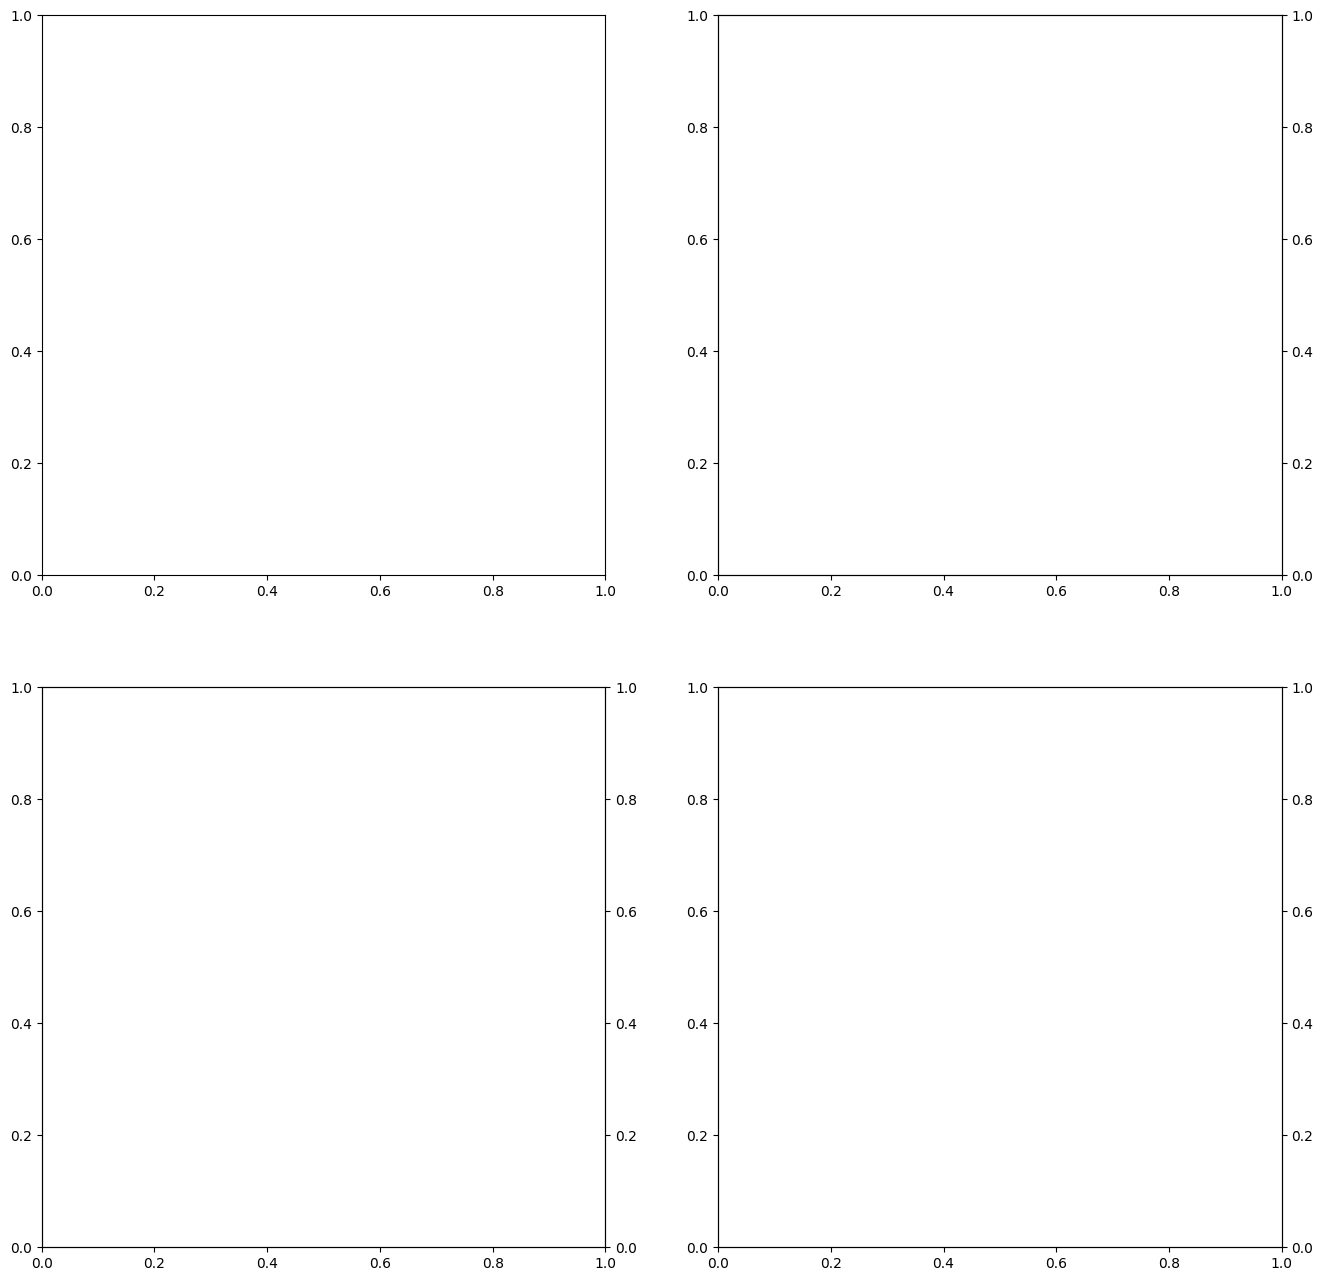

In [2]:
import ipycanvas, matplotlib.pyplot

#figure, ((input_domain_ax, loss_ax), (norms_ax, loss_gradient_inner_product_to_norm_ratio_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
figure, ((input_domain_ax, norms_ax), (loss_gradient_inner_product_to_norm_ratio_ax, inner_products_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
#loss_ax = norms_ax.twinx()
directions_ax = norms_ax.twinx()
neurons_ax = inner_products_ax.twinx()
unique_neurons_angles_ax = loss_gradient_inner_product_to_norm_ratio_ax.twinx()

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)
canvas

In [3]:
import os, sys, numpy, copy, tqdm, cvxpy

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import initialize, extract_samples, ExponentialLoss, accuracy
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from settings.sphere_2d_epsilon_net import get_clusters_means_and_labels
from settings.gaussian_clusters import get_dataloader

variances = numpy.logspace(-5, 0, 6)
variances_results = []
for within_cluster_variance in tqdm.tqdm(variances[:1]):
    experiment = {
        'epsilon': .4,
        'seed': 3,
        'input_dimension': 2, 
        'classes': 2,
        'sample_size': 100,  
        'batch_size': 100, 
        'epochs': 1000,
        'learning_rate': .1,
        'bias': False,
        'initialization_scale': 1.e-10,
        'initial_hidden_units': 500,
        'within_cluster_variance': within_cluster_variance,
        'name_parameters': ['id', 'within_cluster_variance'],
        'id': 'extra_clusters'
    }
    train_loss = ExponentialLoss
    rotation_matrix = numpy.identity(experiment['input_dimension'])
    device, generator = initialize(experiment['seed'])
    clusters_means, clusters_labels = get_clusters_means_and_labels(**experiment)
    train_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                                rotation_matrix=rotation_matrix, generator=generator)
    test_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                                rotation_matrix=rotation_matrix, generator=generator)
    inputs, labels = extract_samples(train_data)

    model_summary_ = functools.partial(model_summary, inputs=inputs)
    plot_samples_and_neurons_ = functools.partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
    plot_angle_linesearch_ = functools.partial(plot_angle_linesearch, ax_inner_products=inner_products_ax, ax_neurons=neurons_ax, inputs=inputs, labels=labels)
    plot_unique_neuron_angles_ = functools.partial(plot_unique_neuron_angles, ax=unique_neurons_angles_ax, legend_loc='upper left')
    plot_weights_norms_ = functools.partial(plot_weights_norms, ax=norms_ax)
    plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
    plot_loss_gradient_inner_product_to_norm_ratio_ = functools.partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
    draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
    save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

    experiment_stage1_result, model, device, generator = execute_experiment(
        **experiment,
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
        overwrite=True,
        callbacks=[
                lambda *args, **kwargs: figure.suptitle(f'$\\sigma$ = {within_cluster_variance:.0e}', fontsize=16),
                plot_angle_linesearch_, 
                plot_changes_in_directions_,
                plot_weights_norms_, 
                plot_loss_gradient_inner_product_to_norm_ratio_,
                plot_unique_neuron_angles_,
                plot_samples_and_neurons_,
                draw_figure_into_canvas_, 
                save_figure_
        ],
        train_data_callbacks=[model_summary_]
    )

    predictions = model(inputs)
    neurons_norms = model.norms.detach().cpu().numpy()
    num_neurons = len(neurons_norms)
    normalized_margins = ((labels * 2. - 1.).unsqueeze(1) * model.output_layer.weight * model.activations[-1] / model.norms.unsqueeze(0)).detach().cpu().numpy()
    new_model = FullyConnectedNeuralNetwork(**{**experiment, 'initial_hidden_units': num_neurons})
    with torch.no_grad():
        new_model.input_layer.weight.copy_(model.input_layer.weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)

    regularization_values = [0.001]#numpy.logspace(-12, 4, num=1000)
    magnitude_optimizations_results = []
    for regularization in tqdm.tqdm(regularization_values):
        # Construct the problem.
        alpha = cvxpy.Variable(num_neurons, nonneg=True)
        alpha.value = neurons_norms
        objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
        problem = cvxpy.Problem(objective)

        # The optimal objective value is returned by `prob.solve()`.
        result = problem.solve(warm_start=True)
        # The optimal value for x is stored in `x.value`.
        #print(alpha.value)
        #print(problem.status)

        with torch.no_grad():
            new_model.output_layer.weight.copy_(torch.tensor(alpha.value))

        experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'magnitude_optimization', 'regularization': regularization}
        predictions = new_model(inputs)
        for callback in [
            model_summary_,
            plot_angle_linesearch_, 
            plot_changes_in_directions_,
            plot_weights_norms_, 
            plot_loss_gradient_inner_product_to_norm_ratio_,
            plot_samples_and_neurons_,
            draw_figure_into_canvas_,
            save_figure_
        ]:
            callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

        magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

    variances_results.append(magnitude_optimizations_results)

  0%|          | 0/1 [00:00<?, ?it/s]/workspaces/adaptive_size_networks/notebooks/utils/models.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return (weights_products.T * self.output_layer.weight.norm(dim=0)).squeeze()


: 

In [10]:
axes

array([<Axes: title={'center': '$\\sigma = $ 1e-04'}, xlabel='$\\lambda$', ylabel='normalized inner product'>,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\|'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_2953/1126036957.py:15: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$',
/tmp/ipykernel_2953/1126036957.py:28: SyntaxWarning: invalid escape sequence '\|'
  label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


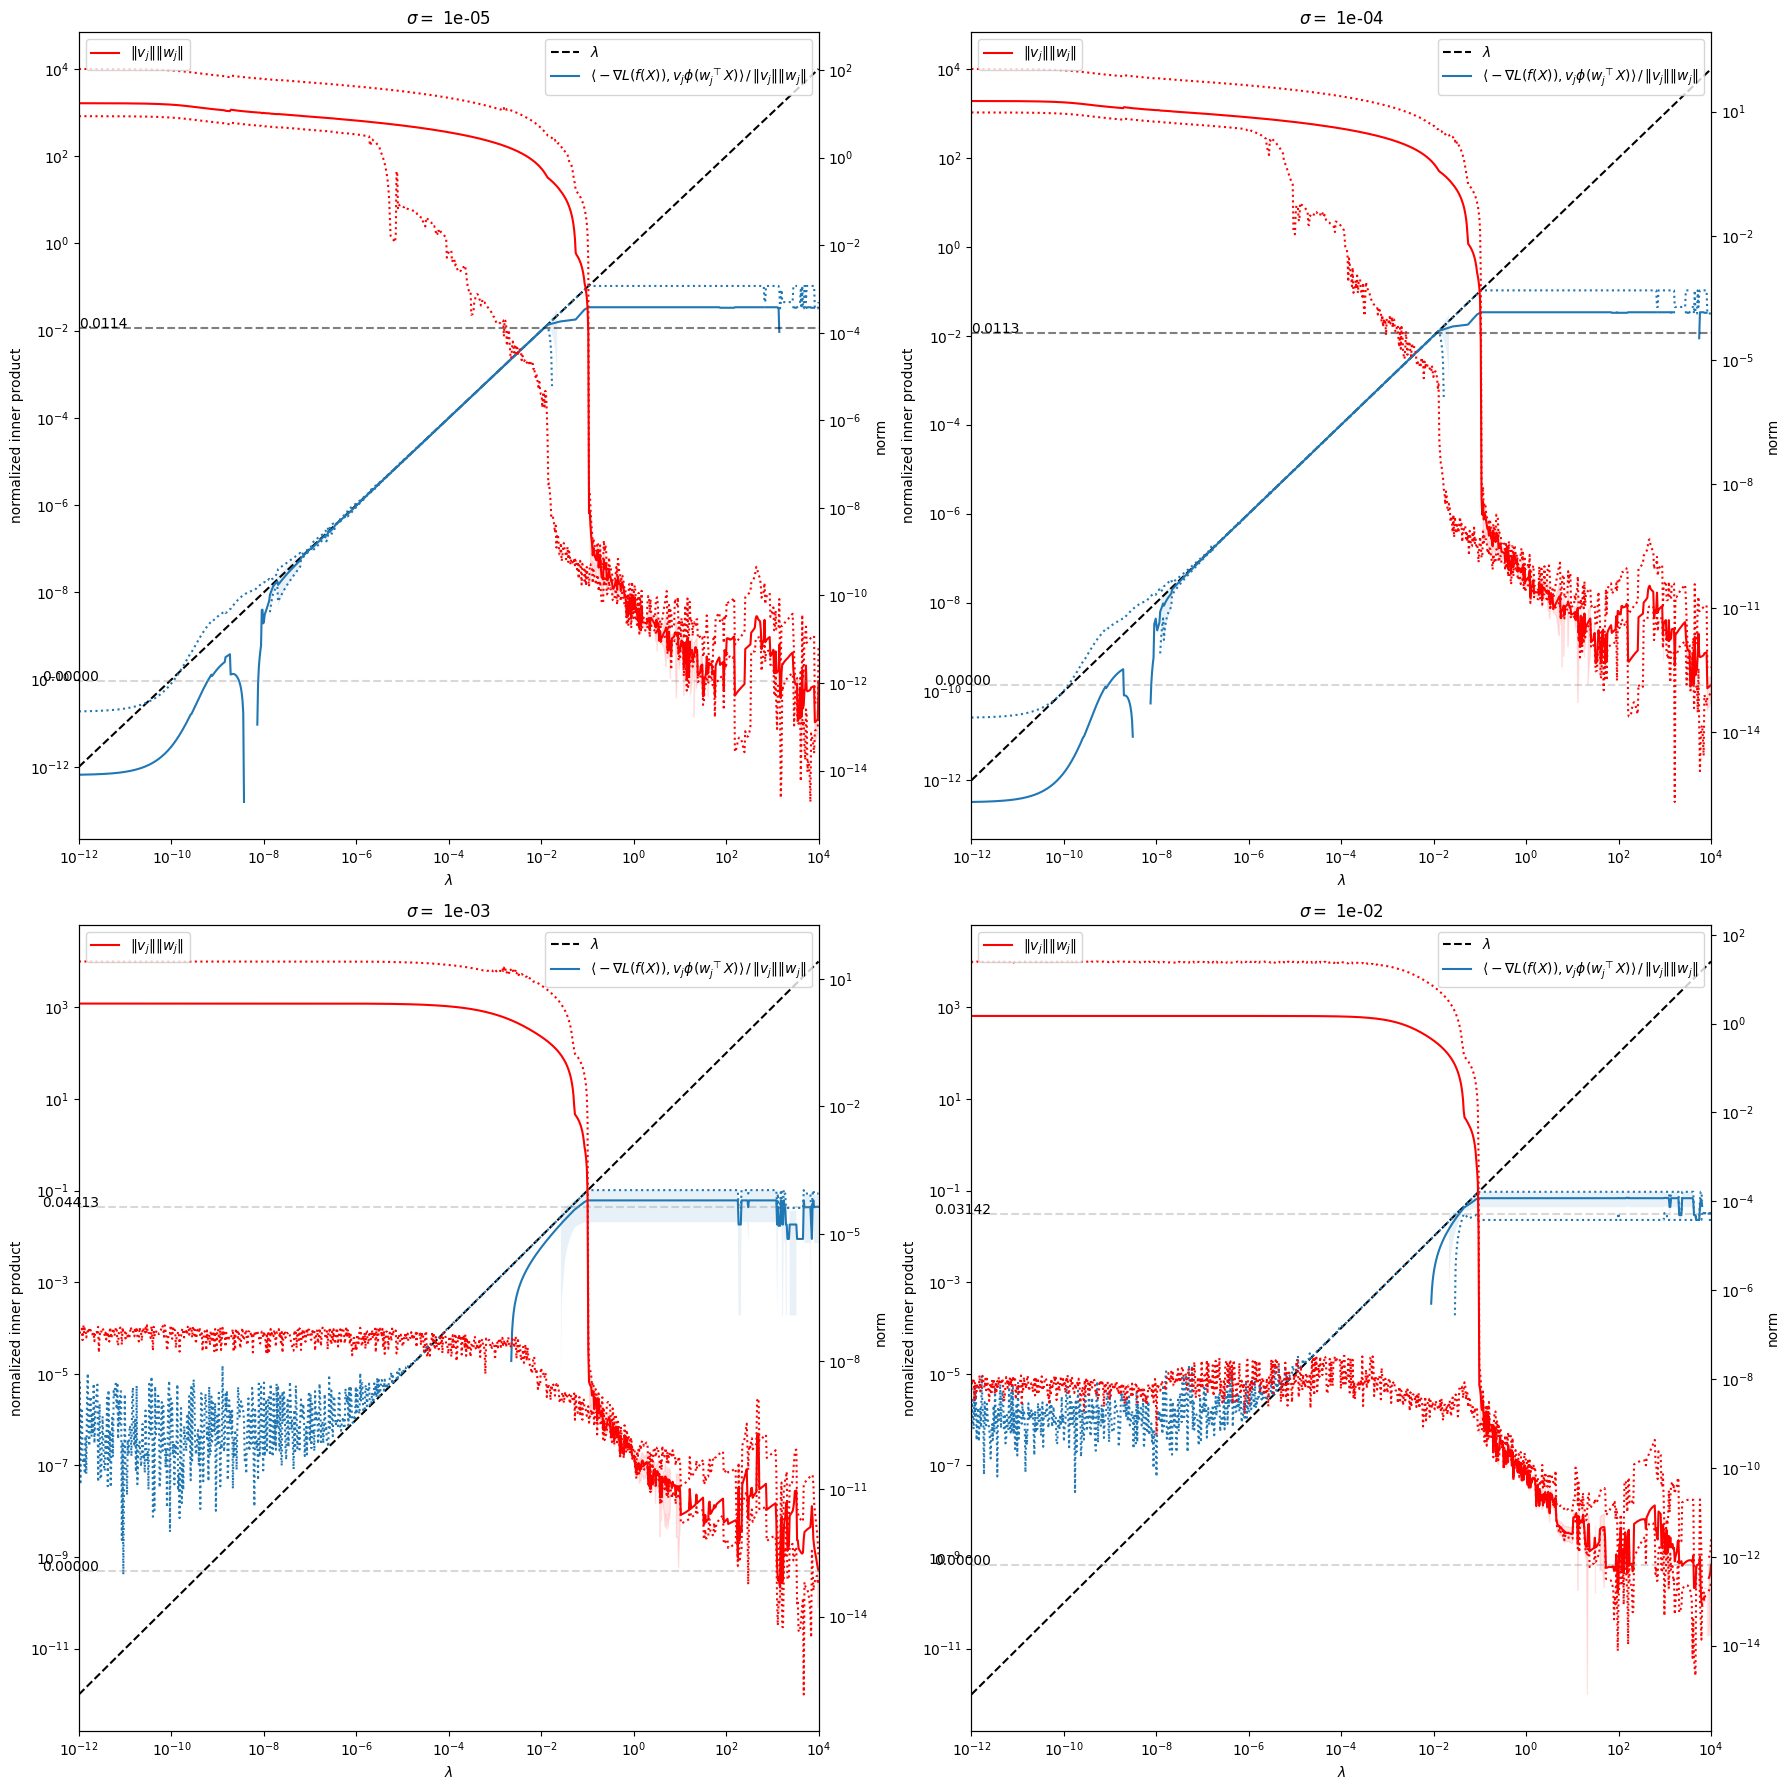

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


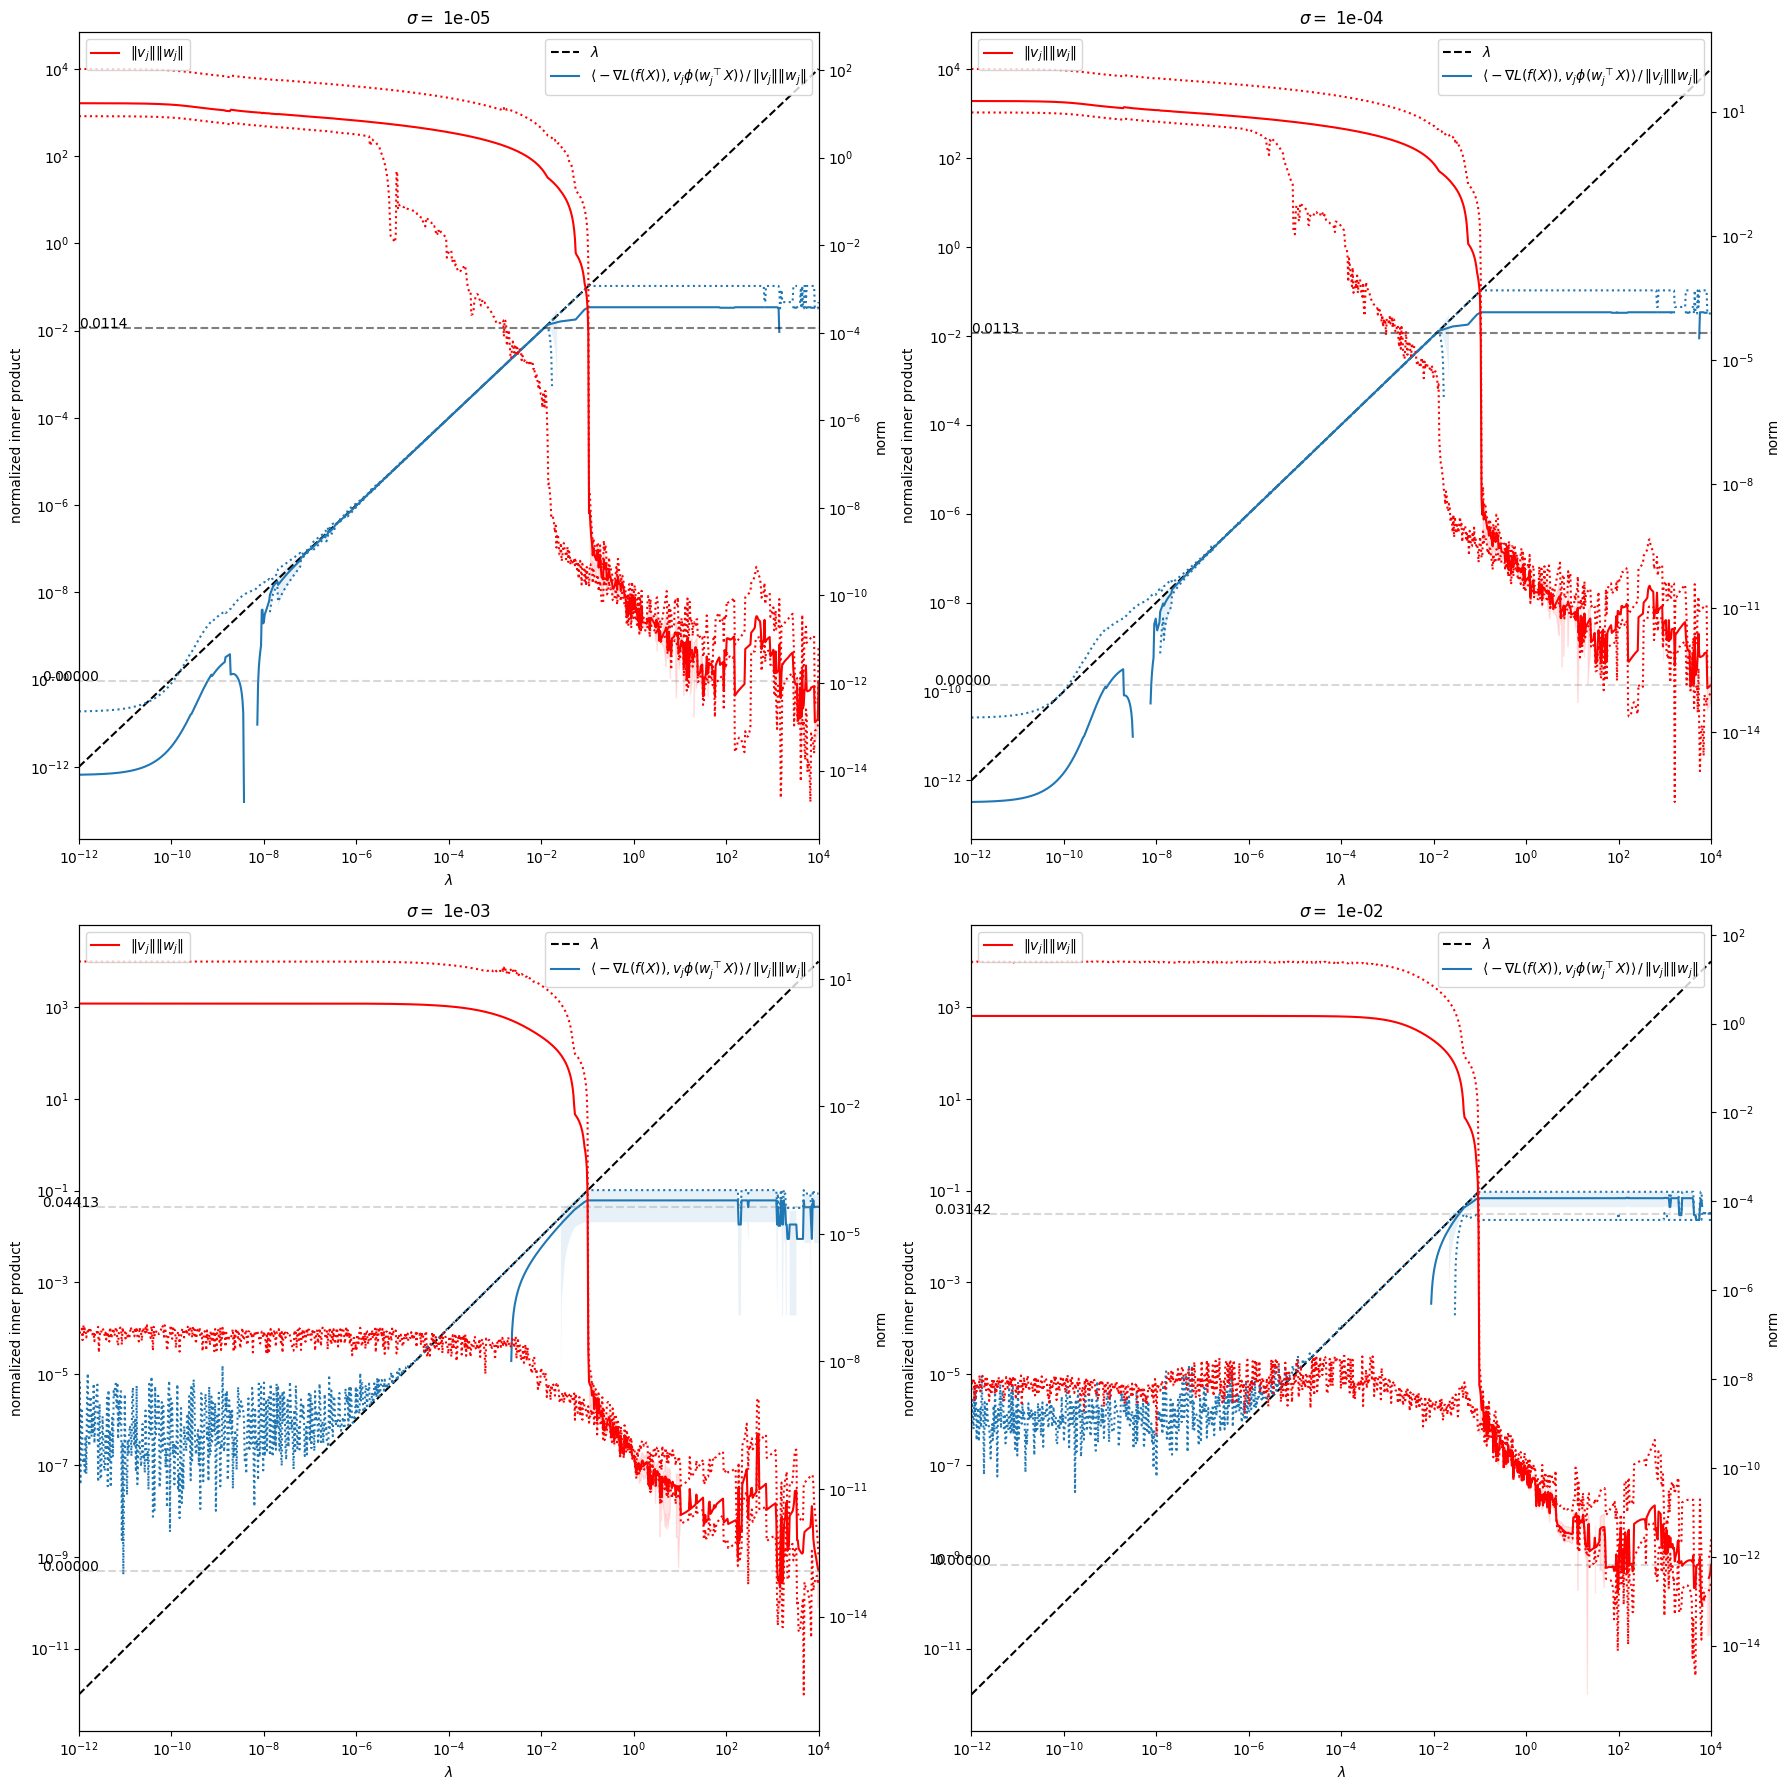

In [20]:
import pandas
from utils.plots import plot_series_and_reference_on_ax

fig, axes = matplotlib.pyplot.subplots(2, 2, figsize=(18, 18))
axes = axes.flatten()
for variance, variance_result, ax in zip(variances[:-1], variances_results[:-1], axes):
    model_metrics_df = pandas.DataFrame(variance_result)
    ax.set_title(f'$\\sigma = $ {variance:.0e}')
    ax.set_xscale('log')
    ax.plot(regularization_values, regularization_values, linestyle='--', c='k', label='$\\lambda$')
    plot_series_and_reference_on_ax(ax, regularization_values, model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].values, 
                                    fill_between_y=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_std'].values, 
                                    lower_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_min'].values, 
                                    upper_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_max'].values,
                                    label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$', 
                                    log_scale=True, 
                                    lower_lim=-1)
    if variance in variances[:2]:
        a = model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].values
        b = numpy.average(a[a>0][:-5])
        ax.hlines(b, min(regularization_values), max(regularization_values), linestyle='--', alpha=.5, color='k')
        ax.text(min(regularization_values), b, f'{b:.4f}', ha='left')
    ax2 = ax.twinx()
    plot_series_and_reference_on_ax(ax2, regularization_values, model_metrics_df['norms_avg'].values, 
                                    fill_between_y=model_metrics_df['norms_std'].values, 
                                    lower_bound=model_metrics_df['norms_min'].values, 
                                    upper_bound=model_metrics_df['norms_max'].values,
                                    label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',
                                    log_scale=True
                                    )
    ax.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_xlabel('$\\lambda$')
    ax.set_ylabel('normalized inner product')
    ax2.set_ylabel('norm')
    ax.set_xlim(regularization_values[0], regularization_values[-1])

fig.tight_layout()
fig

<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\|'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_5720/1755131575.py:14: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$',
/tmp/ipykernel_5720/1755131575.py:22: SyntaxWarning: invalid escape sequence '\|'
  label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',


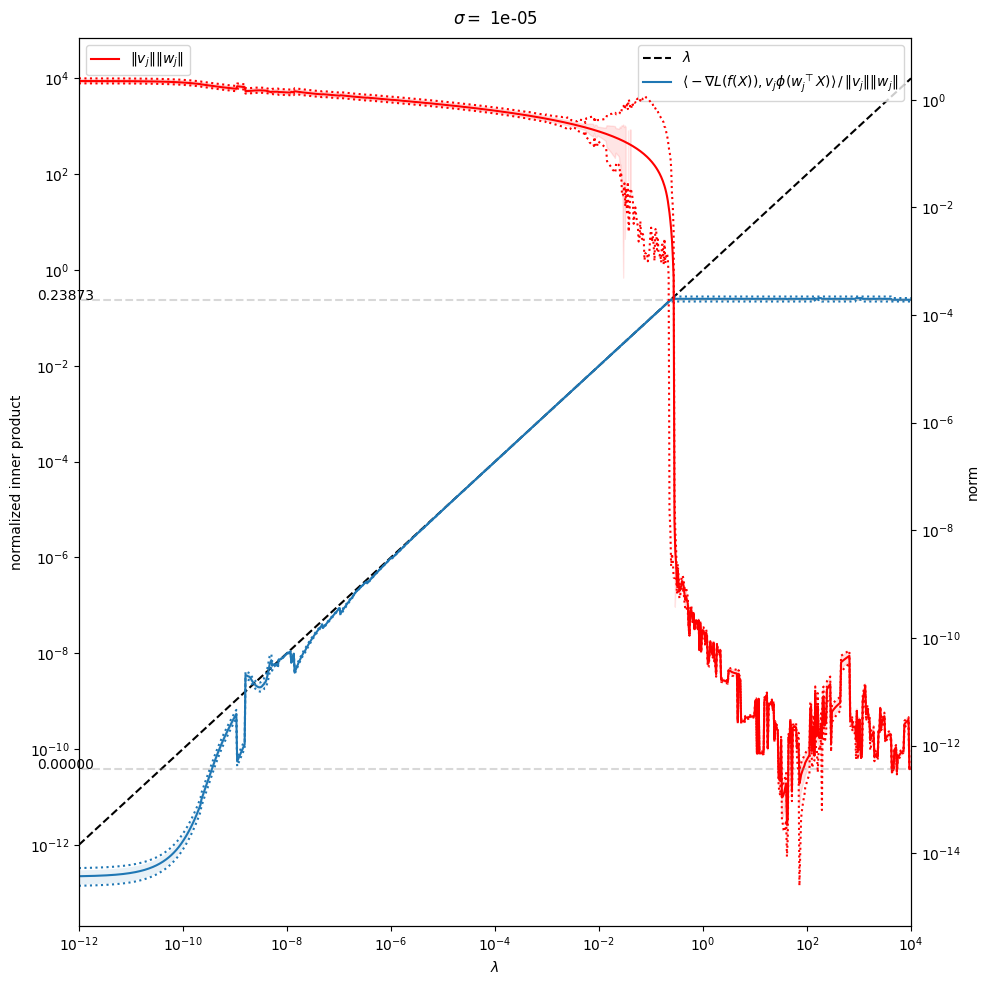

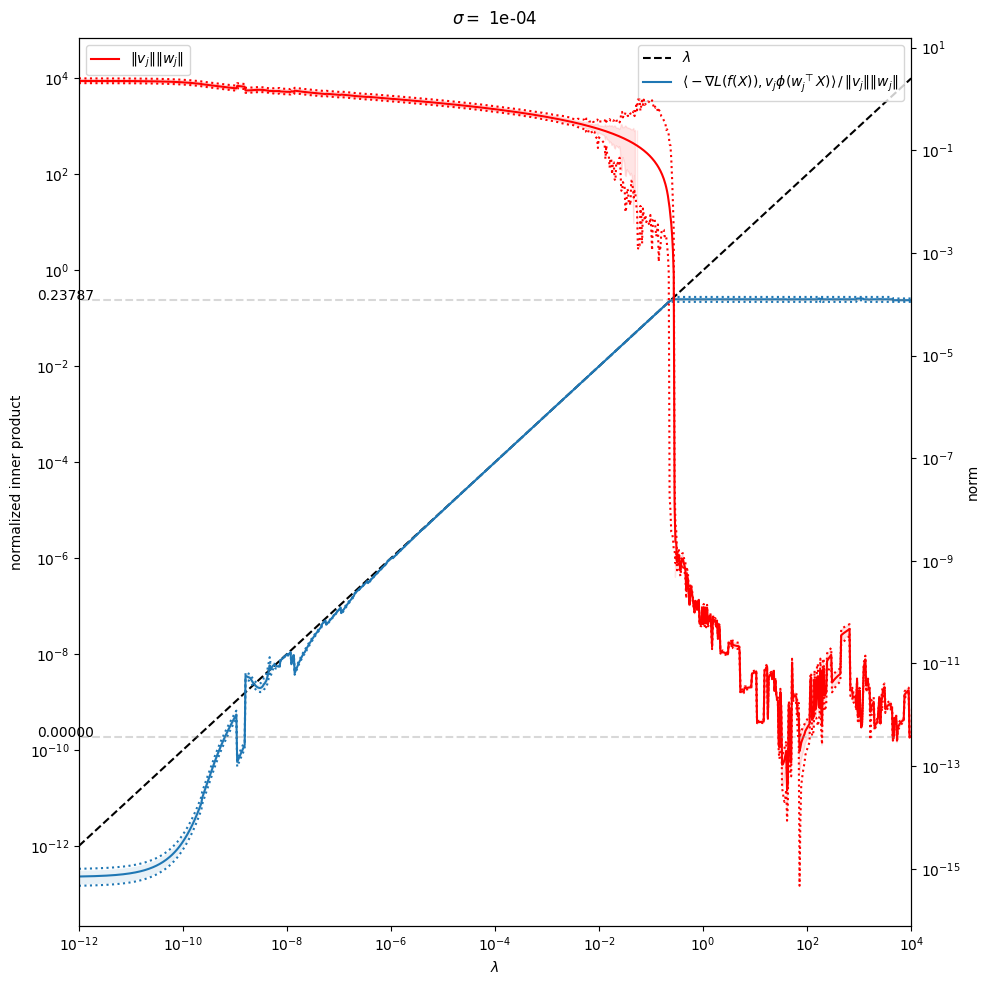

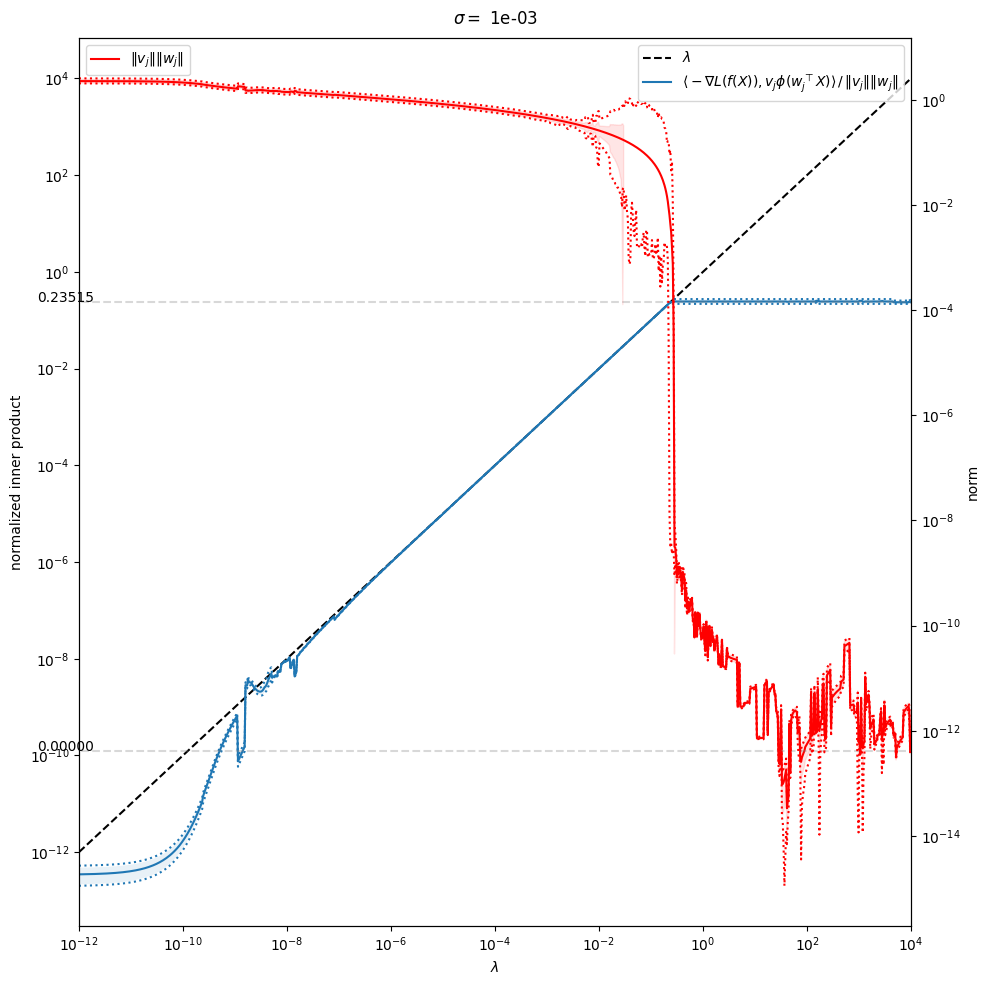

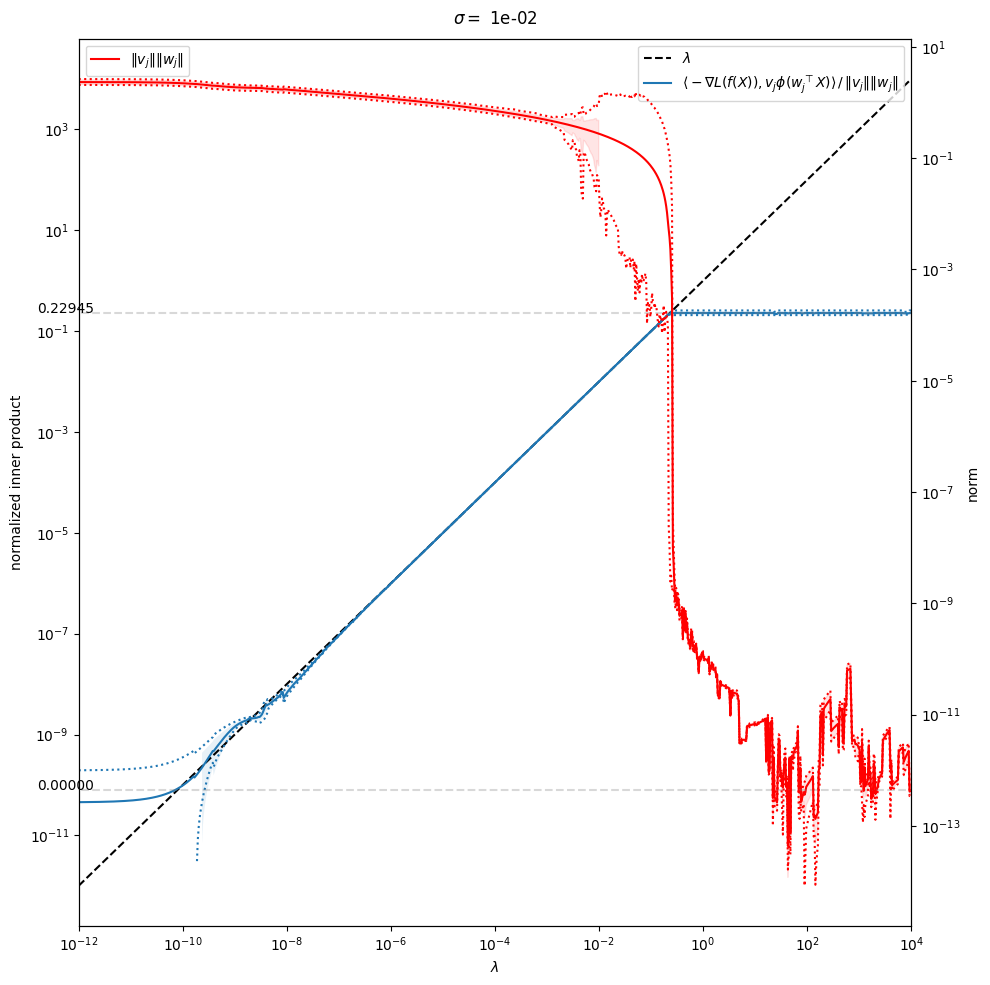

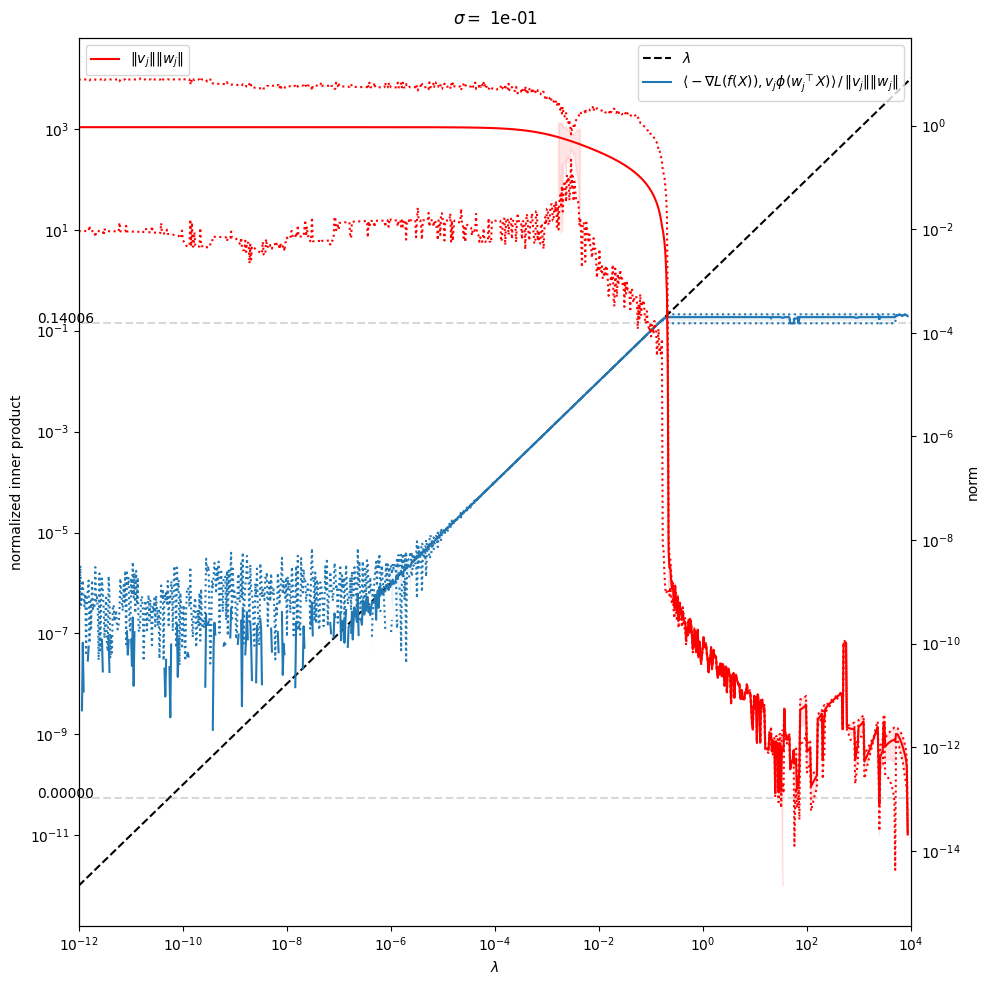

In [5]:
import pandas
from utils.plots import plot_series_and_reference_on_ax, save_figure

for variance, variance_result in zip(variances[1:], variances_results[:1]):
    model_metrics_df = pandas.DataFrame(variance_result)
    fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
    fig.suptitle(f'$\\sigma = $ {variance:.0e}')
    
    ax.set_xscale('log')
    ax.plot(regularization_values, regularization_values, linestyle='--', c='k', label='$\\lambda$')
    plot_series_and_reference_on_ax(ax, regularization_values, model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].values, 
                                    fill_between_y=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_std'].values, 
                                    lower_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_min'].values, 
                                    upper_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_max'].values,
                                    label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$', 
                                    log_scale=True, 
                                    lower_lim=-1)
    ax2 = ax.twinx()
    plot_series_and_reference_on_ax(ax2, regularization_values, model_metrics_df['norms_avg'].values, 
                                    fill_between_y=model_metrics_df['norms_std'].values, 
                                    lower_bound=model_metrics_df['norms_min'].values, 
                                    upper_bound=model_metrics_df['norms_max'].values,
                                    label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',
                                    log_scale=True
                                    )
    ax.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_xlabel('$\\lambda$')
    ax.set_ylabel('normalized inner product')
    ax2.set_ylabel('norm')
    ax.set_xlim(regularization_values[0], regularization_values[-1])
    save_figure(fig, **{**experiment, 'id': 'magnitude_optimization', 'within_cluster_variance': variance, 'name_parameters': ['id', 'within_cluster_variance']})
    #fig

# Regularized problem

In [ ]:
import os, sys, numpy, copy, tqdm

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import initialize, extract_samples, ExponentialLoss, accuracy
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from settings.sphere_2d_epsilon_net import get_clusters_means_and_labels
from settings.gaussian_clusters import get_dataloader

variances = numpy.logspace(-4, -1, 4)
variances_results = []
for within_cluster_variance in tqdm.tqdm(variances):
    experiment = {
        'epsilon': .8,
        'seed': 3,
        'input_dimension': 2, 
        'classes': 2,
        'sample_size': 100,  
        'batch_size': 100, 
        'epochs': 1000,
        'learning_rate': .1,
        'bias': False,
        'initialization_scale': 1.e-10,
        'initial_hidden_units': 50,
        'within_cluster_variance': within_cluster_variance,
        'name_parameters': ['within_cluster_variance']
    }
    train_loss = ExponentialLoss
    rotation_matrix = numpy.identity(experiment['input_dimension'])
    device, generator = initialize(experiment['seed'])
    clusters_means, clusters_labels = get_clusters_means_and_labels(**experiment)
    train_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                                rotation_matrix=rotation_matrix, generator=generator)
    test_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
                                rotation_matrix=rotation_matrix, generator=generator)

    regularization_values = numpy.logspace(-12, 4, num=1000)
    regularization_results = []
    for regularization in tqdm.tqdm(regularization_values):
        experiment['regularization'] = regularization
        experiment_stage1_result, model, device, generator = execute_experiment(
            **experiment,
            train_data=train_data, 
            test_data=test_data, 
            model_class=FullyConnectedNeuralNetwork,
            train_loss_class=train_loss,
            callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
            overwrite=True,
            #callbacks=[
            #        lambda *args, **kwargs: figure.suptitle(f'$\\sigma$ = {within_cluster_variance:.0e}', fontsize=16),
            #        plot_angle_linesearch, 
            #        plot_changes_in_directions,
            #        plot_weights_norms, 
            #        plot_loss_gradient_inner_product_to_norm_ratio,
            #        plot_unique_neuron_angles,
            #        plot_samples_and_neurons,
            #        draw_figure_into_canvas, 
            #        save_figure
            #],
            train_data_callbacks=[model_summary]
        )
        regularization_results.append(experiment_stage1_result['model_metrics'][-1])

    variances_results.append(regularization_results)

  0%|          | 0/4 [00:00<?, ?it/s]

/workspaces/adaptive_size_networks/notebooks/utils/models.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return (weights_products.T * self.output_layer.weight.norm(dim=0)).squeeze()
100%|██████████| 4/4 [04:17<00:00, 64.28s/it]


<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\|'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_2131/4154185560.py:15: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$',
/tmp/ipykernel_2131/4154185560.py:23: SyntaxWarning: invalid escape sequence '\|'
  label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


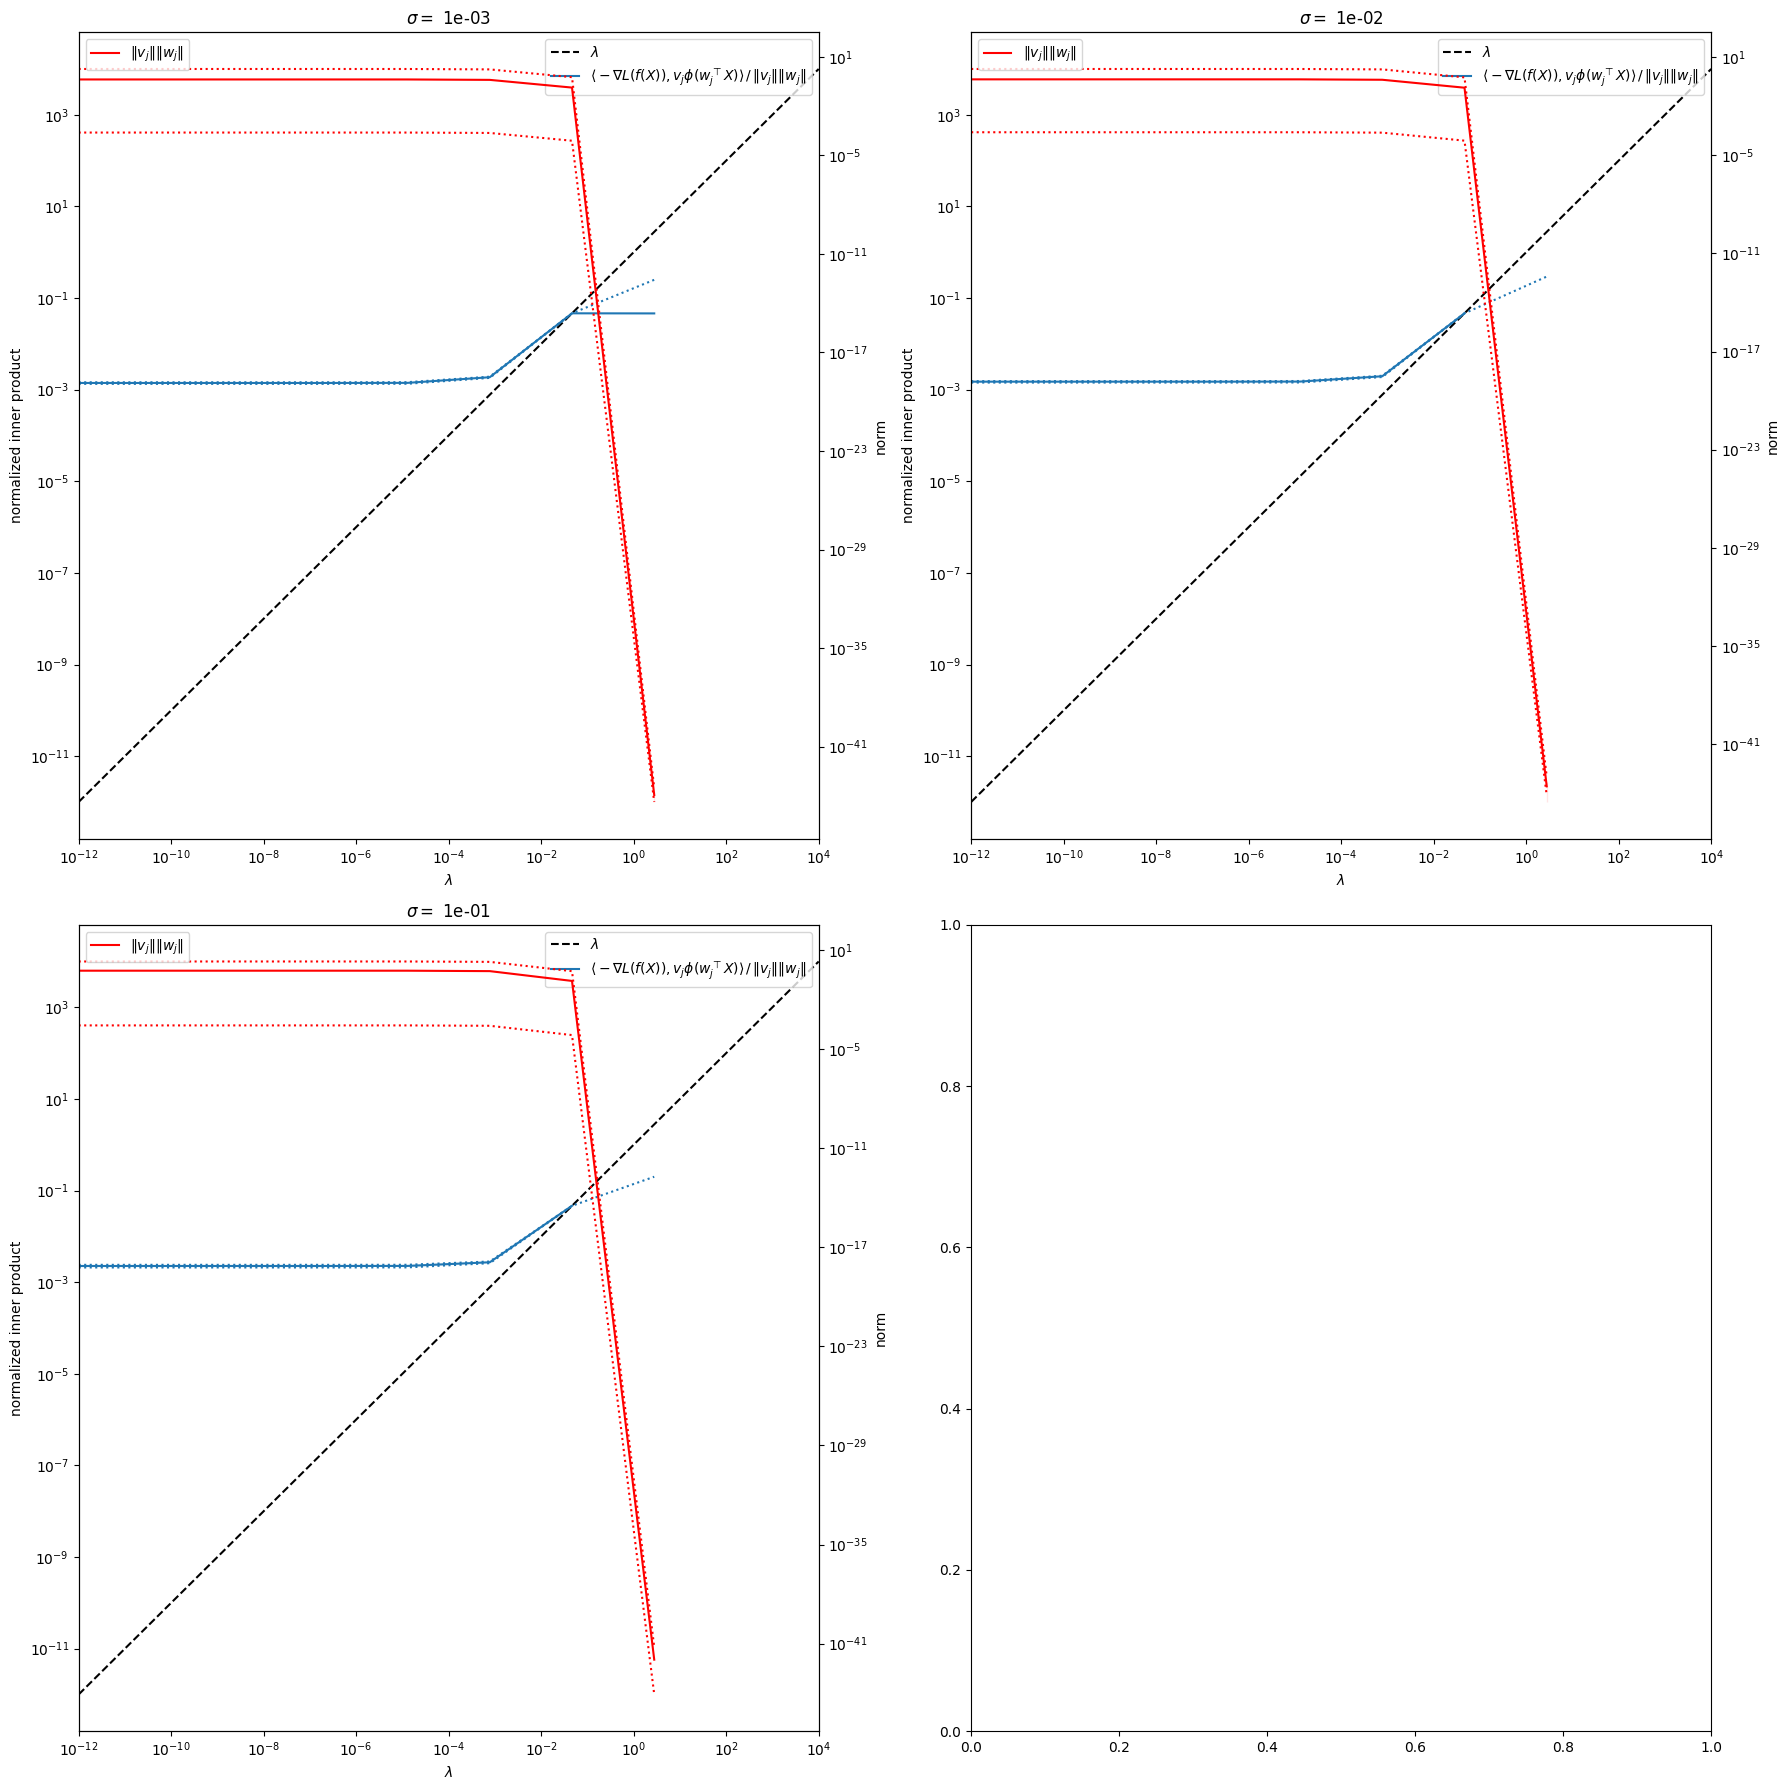

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


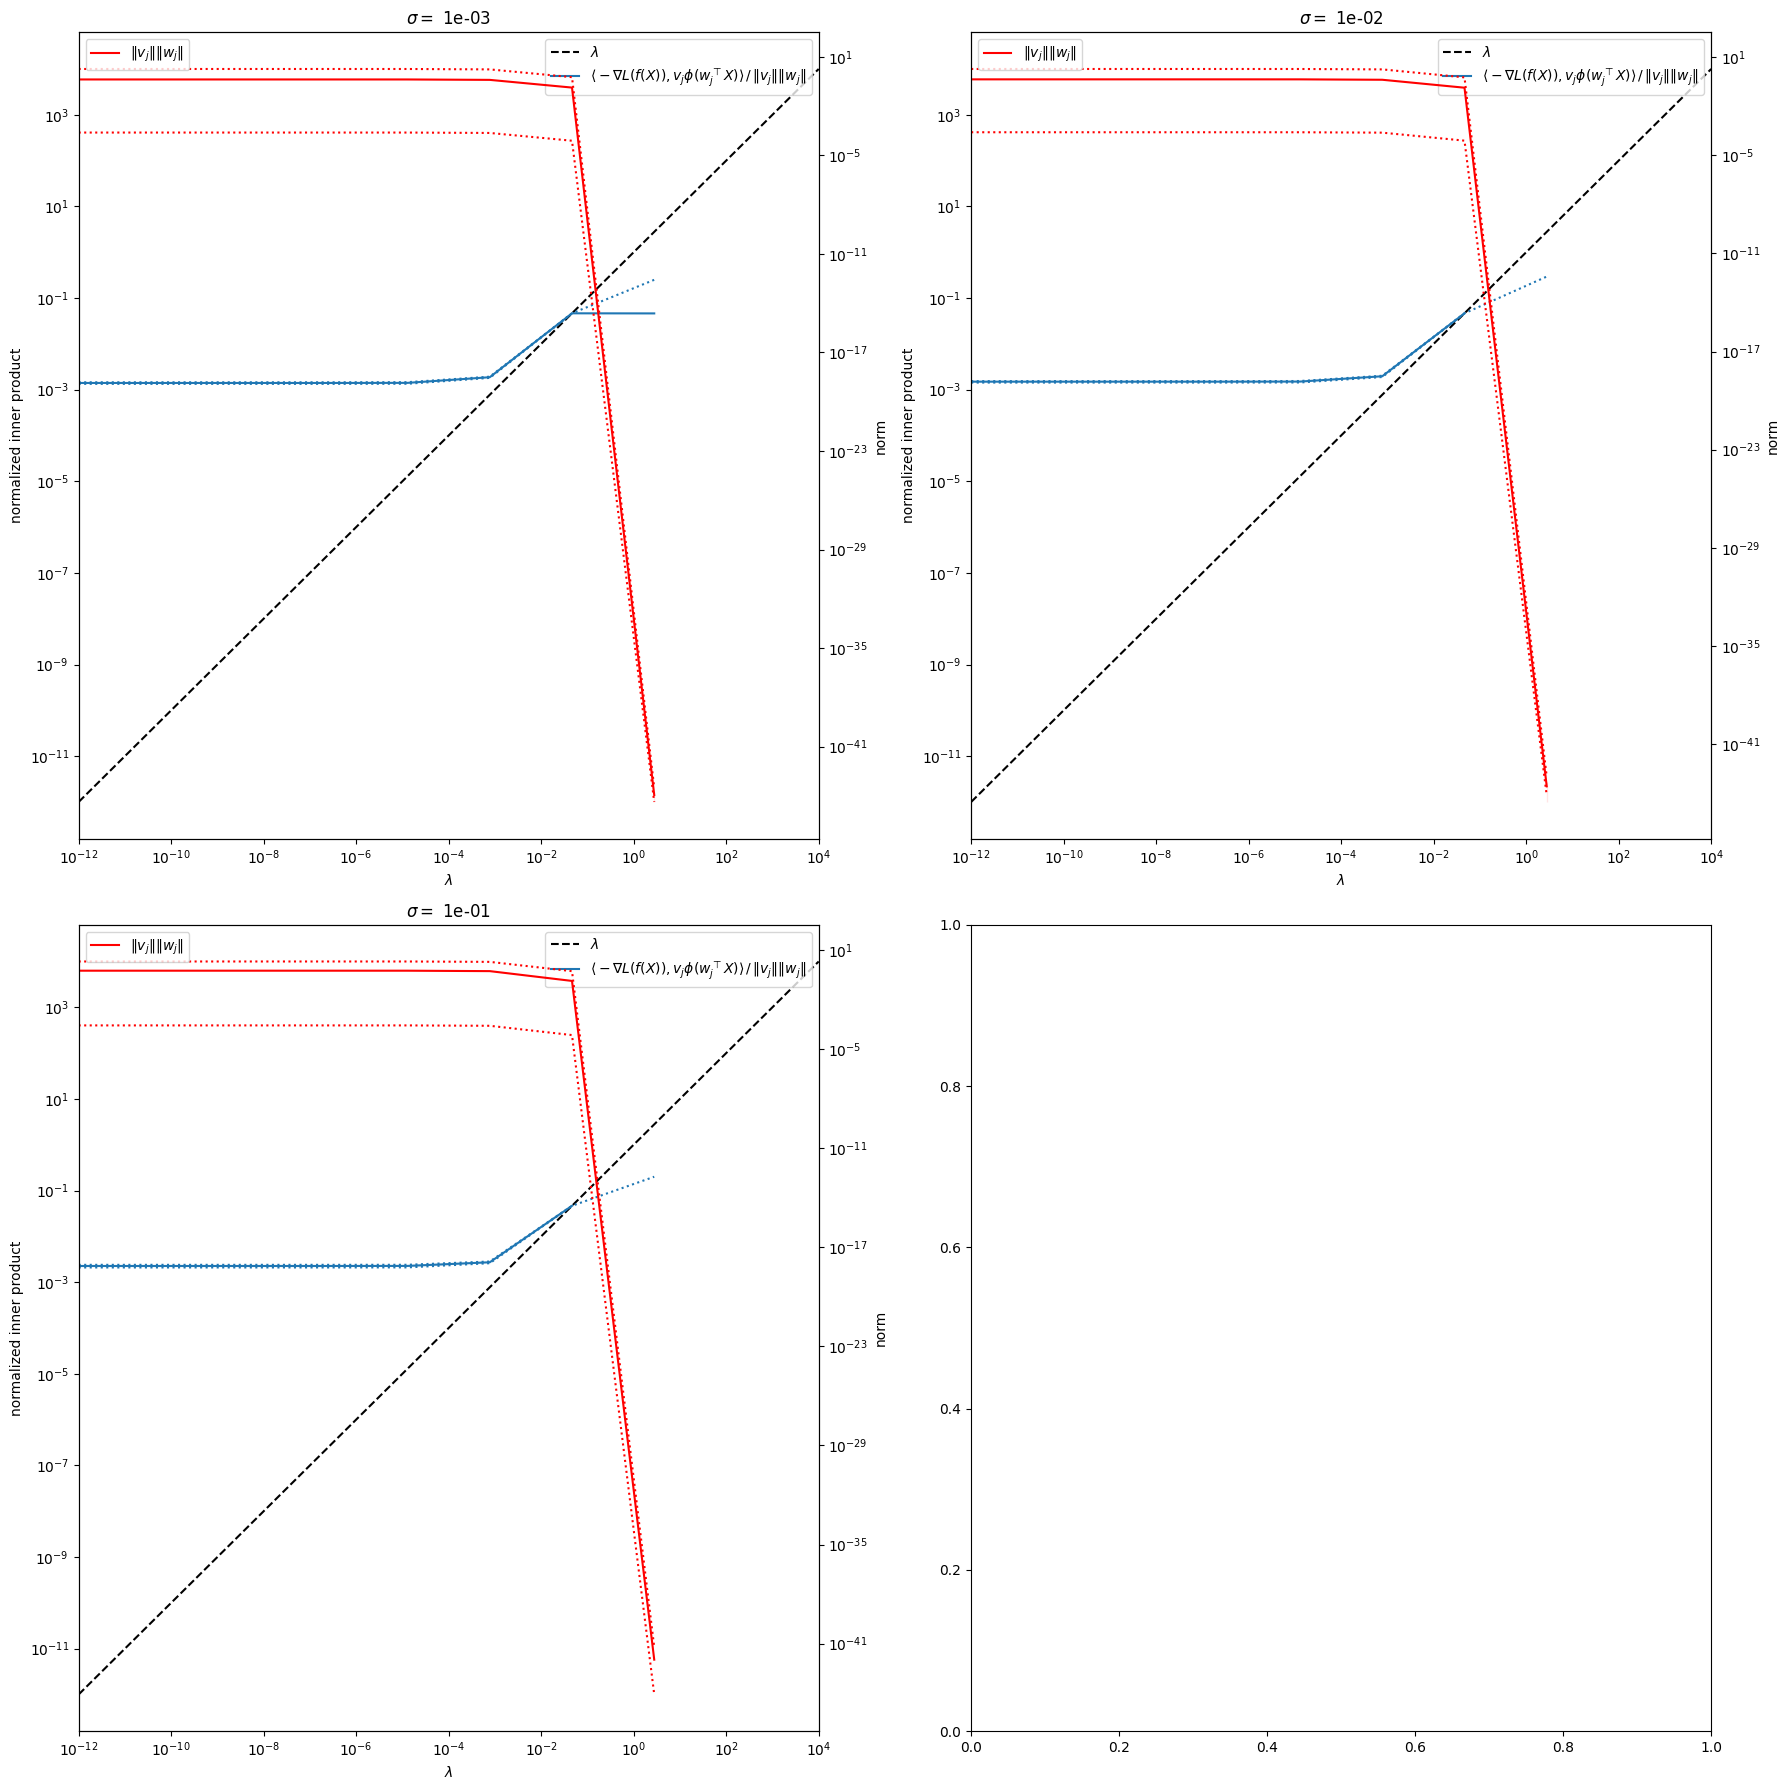

In [4]:
import pandas
from utils.plots import plot_series_and_reference_on_ax

fig, axes = matplotlib.pyplot.subplots(2, 2, figsize=(18, 18))
axes = axes.flatten()
for variance, variance_result, ax in zip(variances[1:], variances_results[1:], axes):
    model_metrics_df = pandas.DataFrame(variance_result)
    ax.set_title(f'$\\sigma = $ {variance:.0e}')
    ax.set_xscale('log')
    ax.plot(regularization_values, regularization_values, linestyle='--', c='k', label='$\\lambda$')
    plot_series_and_reference_on_ax(ax, regularization_values, model_metrics_df['loss_gradient_inner_product_to_norm_ratio_avg'].values, 
                                    fill_between_y=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_std'].values, 
                                    lower_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_min'].values, 
                                    upper_bound=model_metrics_df['loss_gradient_inner_product_to_norm_ratio_max'].values,
                                    label=f'$\langle-\\nabla L(f(X)), v_j \phi(w_j^\\top X)\\rangle \, / \, \|v_j\|\|w_j\|$', 
                                    log_scale=True, 
                                    lower_lim=-1)
    ax2 = ax.twinx()
    plot_series_and_reference_on_ax(ax2, regularization_values, model_metrics_df['norms_avg'].values, 
                                    fill_between_y=model_metrics_df['norms_std'].values, 
                                    lower_bound=model_metrics_df['norms_min'].values, 
                                    upper_bound=model_metrics_df['norms_max'].values,
                                    label=f'$\|v_j\|\|w_j\|$', lower_lim=0, color='red',
                                    log_scale=True
                                    )
    ax.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_xlabel('$\\lambda$')
    ax.set_ylabel('normalized inner product')
    ax2.set_ylabel('norm')
    ax.set_xlim(regularization_values[0], regularization_values[-1])

fig.tight_layout()
fig

In [20]:


#experiment_stage2 = {**copy.deepcopy(experiment_stage2), 'epoch': 1001}
for callback in [
plot_samples_and_neurons,
plot_changes_in_directions,
plot_weights_norms, 
plot_loss_gradient_inner_product_to_norm_ratio,
plot_samples_and_neurons,
draw_figure_into_canvas
]:
    callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=new_model(inputs), **experiment_stage2)

tensor([7.9520e-11, 8.5696e-11, 7.9520e-11, 8.8936e-11, 7.9520e-11, 7.8709e-11,
        7.8709e-11, 8.8936e-11, 7.9520e-11, 8.8936e-11, 8.5696e-11, 8.5696e-11,
        7.8709e-11, 7.8709e-11, 8.8936e-11, 7.8709e-11, 8.5696e-11, 8.5696e-11,
        8.8936e-11, 7.9520e-11, 7.9520e-11, 7.8709e-11, 7.8709e-11, 7.8709e-11,
        8.8936e-11, 8.8936e-11, 8.5696e-11, 7.8709e-11, 8.8936e-11, 7.9520e-11,
        8.5696e-11, 7.9520e-11, 7.9520e-11, 7.8709e-11, 7.8709e-11, 8.5696e-11,
        7.9520e-11, 7.9520e-11, 7.8709e-11, 8.8936e-11, 8.8936e-11, 7.9520e-11,
        8.5696e-11, 8.5696e-11, 8.8936e-11, 8.8936e-11, 7.9520e-11, 8.8936e-11,
        7.9520e-11, 8.5696e-11], grad_fn=<SqueezeBackward0>)

In [4]:
def deambiguate_neurons_by_angle(model, angle_decimals=3, **kwargs):
    neurons_angles = torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).round(decimals=angle_decimals)
    neurons_norms = model.norms
    neurons_signs = torch.sign(model.output_layer.weight).squeeze()
    unique_angles = neurons_angles.unique()
    sum_of_norms = torch.zeros(len(unique_angles))
    signs = torch.zeros(len(unique_angles))
    for neuron_index, neuron_angle in enumerate(neurons_angles):
        deambiguated_neuron_index = unique_angles.detach().tolist().index(neuron_angle)
        sum_of_norms[deambiguated_neuron_index] += neurons_norms[neuron_index]
        signs[deambiguated_neuron_index] += neurons_signs[neuron_index]

    unique_directions = torch.stack([unique_angles.cos(), unique_angles.sin()], dim=1)
    new_model = FullyConnectedNeuralNetwork(**{**kwargs, 'initial_hidden_units': len(unique_directions)})
    with torch.no_grad():
        new_model.input_layer.weight.copy_(unique_directions * sum_of_norms.unsqueeze(1) ** 0.5)
        new_model.output_layer.weight.copy_(signs.sign() * sum_of_norms ** 0.5)

    return new_model


In [5]:
new_model = deambiguate_neurons_by_angle(model, **experiment_stage1_result)
experiment_stage2 = {
    **copy.deepcopy(experiment_stage1_result), 'epochs': experiment['epochs'] * 2, 'regularization': 0.01
}
experiment_stage2, model_stage2, device, generator_stage2 = execute_experiment(
    **experiment_stage2,
    model=new_model,
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment_stage2['epochs'], experiment_stage2['epochs'])),
    callbacks=[
            plot_angle_linesearch,
            plot_weights_norms, 
            plot_loss_gradient_inner_product_to_norm_ratio,
            plot_samples_and_neurons,
            draw_figure_into_canvas, 
            save_figure
    ],
    overwrite=True,
    train_data_callbacks=[model_summary,],
)

In [6]:
model_stage2.norms

tensor([3.2610, 3.4165, 3.4511, 3.3379], grad_fn=<SqueezeBackward0>)

In [8]:


experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001}
for callback in [
#plot_non_zero_norms, #plot_reconstruction_loss,
plot_angle_linesearch, 
#plot_train_loss, 
plot_changes_in_directions,
plot_weights_norms, 
plot_loss_gradient_inner_product_to_norm_ratio,
plot_samples_and_neurons,
draw_figure_into_canvas
]:
    callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=new_model(inputs), **experiment_stage2)

tensor([[-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [-1.0000,  0.0092],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0032, -1.0000],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0.9999],
        [ 0.0104,  0

In [7]:
class MagnitudeOptimizer(torch.nn.Module):

    def __init__(self, backbone, device, *args, **kwargs):
        super(MagnitudeOptimizer, self).__init__()
        for parameter in backbone.parameters(): parameter.requires_grad = False
        self.backbone = backbone
        self.device = device
        classes, backbone_dimention  = backbone.output_layer.weight.shape
        self.output_layer = torch.nn.Linear(backbone_dimention, classes, bias=False)
        with torch.no_grad():
            self.output_layer.weight.copy_(backbone.norms)
            backbone.layers[0].weight.copy_(backbone.layers[0].weight / backbone.layers[0].weight.norm(dim=1).unsqueeze(1))
            backbone.output_layer.weight.copy_(backbone.output_layer.weight / backbone.output_layer.weight.norm(dim=0))

    def forward(self, x):
        self.backbone(x)
        x = self.backbone.activations[-1] * self.backbone.output_layer.weight
        self.activations = [x]
        x = self.output_layer(x).squeeze()
        self.output = x
        self.output.retain_grad()
        return x
    
    @property
    def layers(self):
        return self.backbone.layers
    
    @property
    def dead_units(self):
        return [self.output_layer.weight.squeeze().nonzero().detach().cpu().tolist()]
    
    @property
    def norms(self):
        return self.output_layer.weight.abs().squeeze()
    
    @property
    def input_layer(self):
        return self.backbone.input_layer
    

def prune(model, *args, **kwargs):
    neurons_to_prune = (model.output_layer.weight.flatten() < torch.zeros(model.output_layer.weight.shape[1])).nonzero().flatten().cpu().tolist()
    if neurons_to_prune:
        neurons_to_keep = [neuron_index for neuron_index in range(model.output_layer.weight.shape[1]) if neuron_index not in neurons_to_prune]
        new_backbone = FullyConnectedNeuralNetwork(**{**kwargs, 'initial_hidden_units': len(neurons_to_keep)})
        new_output_layer = torch.nn.Linear(len(neurons_to_keep), model.output_layer.weight.shape[0])
        with torch.no_grad():
            new_backbone.layers[0].weight.copy_(model.backbone.layers[0].weight[neurons_to_keep])
            new_backbone.output_layer.weight.copy_(model.backbone.output_layer.weight[:, neurons_to_keep])
            new_output_layer.weight.copy_(model.output_layer.weight[:, neurons_to_keep])

        for parameter in new_backbone.parameters(): 
            parameter.requires_grad = False

        model.backbone = new_backbone
        model.output_layer = new_output_layer
        return True
    
    return False


In [5]:
regularization_baseline = experiment_stage1_result['model_metrics'][-1]['loss_gradient_inner_product_to_norm_ratio_avg']
experiments_stage2 = []
for regularization_scale in [0., 0.5, 1., 2., 5., 10., 20.]:
    regularization = regularization_baseline * regularization_scale
    experiment_stage2 = {
        **copy.deepcopy(experiment_stage1_result), 'epochs': experiment['epochs'] * 2, 
        'id': f'regularization_scale_{regularization_scale}', 'regularization': regularization
    }
    
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.layers[0].weight.copy_(model.layers[0].weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    experiment_stage2, model_stage2, device, generator_stage2 = execute_experiment(
        **experiment_stage2,
        model=new_model,
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment_stage2['epochs'], experiment_stage2['epochs'])),
        callbacks=[
                plot_angle_linesearch,
                plot_weights_norms, 
                plot_loss_gradient_inner_product_to_norm_ratio,
                plot_samples_and_neurons,
                draw_figure_into_canvas, 
                save_figure
        ],
        overwrite=True,
        train_data_callbacks=[model_summary,],
        pruning_callback=prune
    )
    experiments_stage2.append(experiment_stage2)


In [4]:
matplotlib.pyplot.ioff()
#figure, ((input_domain_ax, loss_ax), (norms_ax, loss_gradient_inner_product_to_norm_ratio_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
figure, ((input_domain_ax, norms_ax), (loss_gradient_inner_product_to_norm_ratio_ax, ax_inner_products)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
#loss_ax = norms_ax.twinx()
directions_ax = norms_ax.twinx()
ax_neurons = ax_inner_products.twinx()

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
#plot_train_loss = partial(plot_train_loss, ax=loss_ax, legend_loc='upper left')
plot_weights_norms = partial(plot_weights_norms, ax=norms_ax)
plot_changes_in_directions = partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_loss_gradient_inner_product_to_norm_ratio = partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

resolution = 1000
step = 10. / float(resolution)
    
def plot_angle_linesearch(model, epoch, sample_size, regularization=None, *args, **kwargs):
    ax_inner_products.clear()
    ax_neurons.clear()
    ax_inner_products.set_title(f'Global optimality condition 2 (Epoch = {epoch})')
    ax_inner_products.set_xlabel('angle')
    ax_inner_products.set_ylabel('inner product')

    angle_line_search = torch.arange(-torch.pi, torch.pi, step)
    signed_labels = labels * 2. - 1.
    margins = signed_labels * model(inputs)
    output_grad = (- margins).exp() * signed_labels / sample_size
    angle_line_search_inner_products = (output_grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs()
    angle_line_search_inner_products = angle_line_search_inner_products.detach().cpu().numpy()
    ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')

    neurons_angles = torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).detach()
    neurons_frequencies, bins = neurons_angles.histogram(resolution // 10)
    bars_width = bins[:-1] - bins[1:]
    ax_neurons.bar(bins[:-1] + bars_width / 2., neurons_frequencies, width=bars_width, color='k', alpha=.5, label='neurons')

    ax_inner_products_ylim = angle_line_search_inner_products.max()
    if regularization:
        ax_inner_products.hlines(regularization, angle_line_search.min(), angle_line_search.max(), color='k', label=f'$\lambda$ = {regularization:.4f}')
        ax_inner_products_ylim = max(ax_inner_products_ylim, regularization)

    ax_inner_products.set_ylim(0, ax_inner_products_ylim * 1.25)
    ax_inner_products.legend(prop={'size': 16}, loc='upper right')
    ax_neurons.legend(prop={'size': 16}, loc='upper left')

canvas

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:46: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:46: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_4515/1120980083.py:37: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')
/tmp/ipykernel_4515/1120980083.py:46: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.hlines(regularization, angle_line_search.min(), angle_line_search.max(), color='k', label=f'$\lambda$ = {regularization:.4f}')


Canvas(height=1200, width=1200)

In [10]:
regularization = .1

import copy
import cvxpy as cp
#model = model_stage2
model(inputs)
neurons_norms = model.norms.detach().cpu().numpy()
num_neurons = len(neurons_norms)

normalized_margins = ((labels * 2. - 1.).unsqueeze(1) * model.output_layer.weight * model.activations[-1] / model.norms.unsqueeze(0)).detach().cpu().numpy()
#normalized_margins *= len(inputs)

# Construct the problem.
alpha = cp.Variable(num_neurons, nonneg=True)
alpha.value = neurons_norms
objective = cp.Minimize(cp.sum(cp.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cp.norm(alpha, 1))
problem = cp.Problem(objective)

# The optimal objective value is returned by `prob.solve()`.
result = problem.solve(warm_start=True)
# The optimal value for x is stored in `x.value`.
print(alpha.value)
print(problem.status)
new_model = FullyConnectedNeuralNetwork(**{**experiment, 'initial_hidden_units': num_neurons})
with torch.no_grad():
    new_model.input_layer.weight.copy_(model.input_layer.weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

new_model = MagnitudeOptimizer(new_model, new_model.device)
with torch.no_grad():
    new_model.output_layer.weight.copy_(torch.tensor(alpha.value))

experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'name_parameters':['id', 'regularization'], 
                     'id': 'L1', 'regularization': regularization, 'epoch': 1001}
for callback in [
    model_summary,
    lambda model_metrics, *args, **kwargs: model_metrics[-1].update({'regularization': regularization}),
    #plot_non_zero_norms, #plot_reconstruction_loss,
    plot_angle_linesearch, 
    #plot_train_loss, 
    plot_changes_in_directions,
    plot_weights_norms, 
    plot_loss_gradient_inner_product_to_norm_ratio,
    plot_samples_and_neurons,
    draw_figure_into_canvas,
    save_figure
]:
    callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=new_model(inputs), **experiment_stage2)


[0.01922195 0.00653059 0.03115937 0.00221534 0.01043047 0.14759539
 0.00319891 0.00869287 0.00419173 0.07172689 0.04333951 0.09415678
 0.00690207 0.0023861  0.01536332 0.00327699 0.02530925 0.00958149
 0.00202268 0.07883172 0.03966605 0.33031616 0.00735012 0.00335804
 0.00158996 0.00452031 0.00508281 0.00239819 0.88341684 0.00282507
 0.3720225  0.01623763 0.00244942 0.00197996 0.2983643  0.10022618
 0.00432463 0.00418402 0.00175654 0.00142149 0.0017968  0.01236885
 0.01596894 0.28735159 0.00135892 0.00167471 0.01948363 0.00188291
 0.59428468 0.0021806 ]
optimal


In [31]:
deambiguate_neurons_by_angle(new_model, **experiment).norms

tensor([8.2683, 8.4733, 8.5572, 8.3572], grad_fn=<SqueezeBackward0>)

In [32]:
fig, ax_inner_products = matplotlib.pyplot.subplots(figsize=(10, 10))
ax_inner_products.clear()
ax_inner_products.set_title(f'Global optimality conditions')
ax_inner_products.set_xlabel('angle')
ax_inner_products.set_ylabel('inner product')

angle_line_search = torch.arange(-torch.pi, torch.pi, step)
signed_labels = labels * 2. - 1.
margins = signed_labels * model(inputs)
output_grad = (- margins).exp() * signed_labels / experiment['sample_size']
angle_line_search_inner_products = (output_grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs()
angle_line_search_inner_products = angle_line_search_inner_products.detach().cpu().numpy()
ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')

neurons_angles = torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).detach()
neurons_frequencies, bins = neurons_angles.histogram(resolution // 10)
bars_width = bins[:-1] - bins[1:]
ax_neurons.bar(bins[:-1] + bars_width / 2., neurons_frequencies, width=bars_width, color='k', alpha=.5, label='neurons')

ax_inner_products_ylim = angle_line_search_inner_products.max()
if regularization:
    ax_inner_products.hlines(regularization, angle_line_search.min(), angle_line_search.max(), color='k', label=f'$\lambda$ = {regularization:.4f}')
    ax_inner_products_ylim = max(ax_inner_products_ylim, regularization)

ax_inner_products.set_ylim(0, ax_inner_products_ylim * 1.25)
ax_inner_products.legend(prop={'size': 16}, loc='upper right')
ax_neurons.legend(prop={'size': 16}, loc='upper left')

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6011/1864676846.py:13: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')
/tmp/ipykernel_6011/1864676846.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.hlines(regularization, angle_line_search.min(), angle_line_search.max(), color='k', label=f'$\lambda$ = {regularization:.4f}')


In [33]:
import copy 

experiments_stage2 = []
for regularization_scale in [0.01]:#[0., 0.001, 0.005, 0.01, 0.05, 0.1]:
    experiment_stage2 = {**copy.deepcopy(experiment), 'regularization': regularization_scale}

    experiment_stage2, model_stage2, device, generator_stage2 = execute_experiment(
        **experiment_stage2,
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment_stage2['epochs'], experiment_stage2['epochs'])),
        callbacks=[
                #plot_non_zero_norms, #plot_reconstruction_loss,
                plot_angle_linesearch, #plot_train_loss, 
                plot_weights_norms, 
                plot_loss_gradient_inner_product_to_norm_ratio,
                plot_samples_and_neurons,
                draw_figure_into_canvas, 
                #save_figure
        ],
        overwrite=True,
        train_data_callbacks=[model_summary]
    )
    experiments_stage2.append(experiment_stage2)


posx and posy should be finite values
posx and posy should be finite values


In [35]:
deambiguate_neurons_by_angle(model_stage2, **experiment).norms

tensor([3.2467, 3.4063, 3.4391, 3.3223], grad_fn=<SqueezeBackward0>)

In [37]:
class MagnitudeOptimizer(torch.nn.Module):

    def __init__(self, backbone, device, *args, **kwargs):
        super(MagnitudeOptimizer, self).__init__()
        for parameter in backbone.parameters(): parameter.requires_grad = False
        self.backbone = backbone
        self.device = device
        classes, backbone_dimention  = backbone.output_layer.weight.shape
        self.output_layer = torch.nn.Linear(backbone_dimention, classes, bias=False)
        with torch.no_grad():
            self.output_layer.weight.copy_(backbone.norms)
            backbone.layers[0].weight.copy_(backbone.layers[0].weight / backbone.layers[0].weight.norm(dim=1).unsqueeze(1))
            backbone.output_layer.weight.copy_(backbone.output_layer.weight / backbone.output_layer.weight.norm(dim=0))

    def forward(self, x):
        self.backbone(x)
        x = self.backbone.activations[-1] * self.backbone.output_layer.weight
        self.activations = [x]
        x = self.output_layer(x).squeeze()
        self.output = x
        self.output.retain_grad()
        return x
    
    @property
    def layers(self):
        return self.backbone.layers
    
    @property
    def dead_units(self):
        return [self.output_layer.weight.squeeze().nonzero().detach().cpu().tolist()]
    
    @property
    def norms(self):
        return self.output_layer.weight.abs().squeeze()
    
    @property
    def input_layer(self):
        return self.backbone.input_layer
    

def prune(model, *args, **kwargs):
    neurons_to_prune = (model.output_layer.weight.flatten() < torch.zeros(model.output_layer.weight.shape[1])).nonzero().flatten().cpu().tolist()
    if neurons_to_prune:
        neurons_to_keep = [neuron_index for neuron_index in range(model.output_layer.weight.shape[1]) if neuron_index not in neurons_to_prune]
        new_backbone = FullyConnectedNeuralNetwork(**{**kwargs, 'initial_hidden_units':len(neurons_to_keep)})
        new_output_layer = torch.nn.Linear(len(neurons_to_keep), model.output_layer.weight.shape[0])
        with torch.no_grad():
            new_backbone.layers[0].weight.copy_(model.backbone.layers[0].weight[neurons_to_keep])
            new_backbone.output_layer.weight.copy_(model.backbone.output_layer.weight[:, neurons_to_keep])
            new_output_layer.weight.copy_(model.output_layer.weight[:, neurons_to_keep])

        for parameter in new_backbone.parameters(): 
            parameter.requires_grad = False

        model.backbone = new_backbone
        model.output_layer = new_output_layer
        return True
    
    return False


In [7]:
new_model = FullyConnectedNeuralNetwork(**experiment_result)
with torch.no_grad():
    new_model.input_layer.weight.copy_(model.input_layer.weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

new_model = MagnitudeOptimizer(new_model, new_model.device)
with torch.no_grad():
    new_model.output_layer.weight.copy_(torch.tensor(alpha.value))

plot_samples_and_neurons(model=new_model)
draw_figure_into_canvas()

In [15]:
plot_samples_and_neurons(model=new_model)
draw_figure_into_canvas()

In [ ]:
matplotlib.pyplot.ioff()
#figure, ((input_domain_ax, loss_ax), (norms_ax, loss_gradient_inner_product_to_norm_ratio_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
figure, ((input_domain_ax, norms_ax), (loss_gradient_inner_product_to_norm_ratio_ax, ax_inner_products)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
#loss_ax = norms_ax.twinx()
directions_ax = norms_ax.twinx()
ax_neurons = ax_inner_products.twinx()

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
#plot_train_loss = partial(plot_train_loss, ax=loss_ax, legend_loc='upper left')
plot_weights_norms = partial(plot_weights_norms, ax=norms_ax)
plot_changes_in_directions = partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_loss_gradient_inner_product_to_norm_ratio = partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

resolution = 1000
step = 10. / float(resolution)
    
def plot_angle_linesearch(model, epoch, regularization=None, *args, **kwargs):
    ax_inner_products.clear()
    ax_neurons.clear()
    ax_inner_products.set_title(f'Global optimality condition 2 (Epoch = {epoch})')
    ax_inner_products.set_xlabel('angle')
    ax_inner_products.set_ylabel('inner product')

    angle_line_search = torch.arange(-torch.pi, torch.pi, step)
    signed_labels = labels * 2. - 1.
    margins = signed_labels * model(inputs)
    output_grad = (- margins).exp() * signed_labels
    angle_line_search_inner_products = (output_grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs()
    angle_line_search_inner_products = angle_line_search_inner_products.detach().cpu().numpy()
    ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, c='b', label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')

    neurons_angles = torch.atan2(model.input_layer.weight[:, 1], model.input_layer.weight[:, 0]).detach()
    neurons_frequencies, bins = neurons_angles.histogram(resolution // 10)
    bars_width = bins[:-1] - bins[1:]
    ax_neurons.bar(bins[:-1] + bars_width / 2., neurons_frequencies, width=bars_width, color='k', alpha=.5, label='neurons')
    datapoints_angles = torch.atan2(inputs[:, 1], inputs[:, 0])
    datapoints_frequencies, _ = datapoints_angles.histogram(bins)
    ax_neurons.bar(bins[:-1] + bars_width / 2., datapoints_frequencies, width=bars_width, color='b', alpha=.5, label='datapoints')

    if regularization is not None:
        ax_inner_products.hline(regularization, angle_line_search.min(), angle_line_search.max(), linestyle='--', color='k', label=f'$\lambda$ = {regularization:.4f}')

    ax_inner_products.set_ylim(0, angle_line_search_inner_products.max() * 1.1)
    ax_inner_products.legend(prop={'size': 16}, loc='upper right')
    ax_neurons.legend(prop={'size': 16}, loc='upper left')

canvas

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:47: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:47: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_8907/1873457620.py:36: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, c='b', label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')
/tmp/ipykernel_8907/1873457620.py:47: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.hline(regularization, angle_line_search.min(), angle_line_search.max(), linestyle='--', color='k', label=f'$\lambda$ = {regularization:.4f}')


Canvas(height=1200, width=1200)

In [6]:
import copy 

regularization_baseline = experiment['model_metrics'][-1]['loss_gradient_inner_product_to_norm_ratio_avg']

experiments_stage2 = []
for regularization_scale in [0., 0.5, 1., 2., 5., 10., 20.]:
    regularization = regularization_baseline * regularization_scale
    def proximal_operator(model, learning_rate, *args, **kwargs):
        for parameter in model.parameters():
            pg.l1(parameter, lr=learning_rate, reg=regularization)
    
    experiment_stage2 = {**copy.deepcopy(experiment), 'epochs': experiment['epochs'] * 2, 'id': f'regularization_scale_{regularization_scale}'}
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.layers[0].weight.copy_(model.layers[0].weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    experiment_stage2, model_stage2, device, generator_stage2 = execute_experiment(
        **experiment_stage2,
        model=new_model,
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment_stage2['epochs'], experiment_stage2['epochs'])),
        callbacks=[
                lambda model_metrics, *args, **kwargs: model_metrics[-1].update({'regularization': regularization}),
                #plot_non_zero_norms, #plot_reconstruction_loss,
                plot_angle_linesearch, #plot_train_loss, 
                plot_weights_norms, 
                plot_loss_gradient_inner_product_to_norm_ratio,
                plot_samples_and_neurons,
                draw_figure_into_canvas, 
                save_figure
        ],
        overwrite=True,
        train_data_callbacks=[model_summary],
        pruning_callback=proximal_operator
    )
    experiments_stage2.append(experiment_stage2)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_18377/1161935634.py:19: SyntaxWarning: invalid escape sequence '\l'
  ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, c='b', label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')


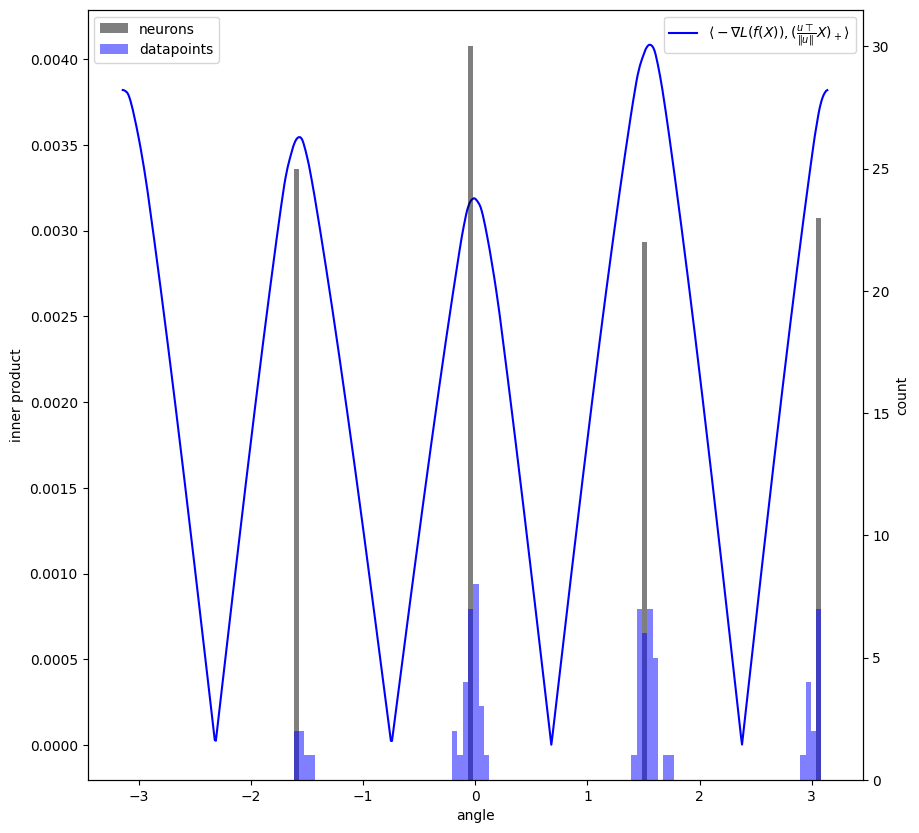

In [101]:
train_loss_func = train_loss()
outputs = new_model(inputs)
outputs.retain_grad()
train_loss_value = train_loss_func(outputs, labels)
train_loss_value.backward(torch.ones_like(train_loss_value))

with torch.no_grad():
    resolution = 1000
    step = 10. / float(resolution)
    angle_line_search = torch.arange(-torch.pi, torch.pi, step)
    angle_line_search_inner_products = (outputs.grad @ torch.relu(inputs @ torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))))).abs()

    fig, ax_inner_products = matplotlib.pyplot.subplots(figsize=(10, 10))
    ax_neurons = ax_inner_products.twinx()

    ax_inner_products.set_xlabel('angle')
    ax_inner_products.set_ylabel('inner product')

    ax_inner_products.plot(angle_line_search, angle_line_search_inner_products, c='b', label='$\langle-\\nabla L(f(X)), (\\frac{u\\top}{\|u\|} X)_+\\rangle$')
    ax_inner_products.legend(loc='upper right')

    ax_neurons.set_ylabel('count')
    neurons_angles = torch.atan2(new_model.backbone.layers[0].weight[:, 1], new_model.backbone.layers[0].weight[:, 0])
    neurons_frequencies, bins = neurons_angles.histogram(100)
    bars_width = bins[:-1] - bins[1:]
    ax_neurons.bar(bins[:-1] + bars_width / 2., neurons_frequencies, width=bars_width, color='k', alpha=.5, label='neurons')
    datapoints_angles = torch.atan2(inputs[:, 1], inputs[:, 0])
    datapoints_frequencies,_ = datapoints_angles.histogram(bins)
    ax_neurons.bar(bins[:-1] + bars_width / 2., datapoints_frequencies, width=bars_width, color='b', alpha=.5, label='datapoints')

    ax_neurons.legend(loc='upper left')
    
fig

In [98]:
datapoints_frequencies

torch.return_types.histogram(
hist=tensor([2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 4., 7., 8., 3.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 7., 6., 7., 5., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 4., 2., 7.]),
bin_edges=tensor([-1.5692, -1.5221, -1.4751, -1.4281, -1.3811, -1.3341, -1.2871, -1.2401,
        -1.1930, -1.1460, -1.0990, -1.0520, -1.0050, -0.9580, -0.9109, -0.8639,
        -0.8169, -0.7699, -0.7229, -0.6759, -0.6289, -0.5818, -0.5348, -0.4878,
        -0.4408, -0.3938, -0.3468, -0.2997, -0.2527, -0.2057, -0.1587, -0.1117,
        -0.0647, -0.0177,  0.0294,  0.0764,  0.1234,  0.1704,  0.2174,  0.2644,
         0.3114,  0.3585,  0.4055,  0.4525,  0.4995,  0.5465,  0.5935,  0.6406,
         0.6876,  0.7346,

In [93]:
frequencies

tensor([25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [81]:
histogram_frequencies

tensor([-1.5692, -1.5645, -1.5598,  ...,  3.1230,  3.1277,  3.1324])

In [76]:
neurons_angles.shape

torch.Size([100])

In [37]:
angle_line_search[0]

tensor(-3.1416)

tensor([ 1.5606,  3.1324,  3.1324, -0.0074, -0.0074, -1.5692,  3.1324,  1.5606,
        -0.0074, -1.5691,  1.5606, -1.5692,  3.1324,  3.1324,  1.5606, -1.5691,
        -0.0074,  1.5606,  3.1324,  3.1324,  1.5606,  1.5606, -0.0074, -0.0074,
         3.1324,  1.5606, -1.5692,  3.1324, -0.0074,  1.5606,  1.5606, -0.0074,
         3.1324, -0.0074, -0.0074, -0.0074, -1.5691, -0.0074, -0.0074, -0.0074,
        -0.0074, -0.0074, -1.5692, -1.5691, -0.0074,  3.1324,  3.1324,  3.1324,
        -1.5692,  1.5606, -0.0074,  3.1324,  3.1324,  1.5606,  1.5606, -1.5691,
         3.1324,  3.1324,  3.1324, -1.5691, -1.5691, -1.5691,  3.1324, -0.0074,
        -1.5691,  1.5606,  1.5606,  3.1324, -0.0074,  3.1324, -0.0074,  1.5606,
        -1.5691, -1.5691, -1.5692, -1.5691,  1.5606,  1.5606, -0.0074, -1.5692,
        -1.5691, -0.0074,  1.5606,  1.5606,  3.1324, -1.5691,  1.5606,  3.1324,
        -0.0074, -0.0074, -1.5691, -0.0074, -1.5691, -1.5692, -0.0074,  1.5606,
        -1.5692, -0.0074, -0.0074, -0.00

In [54]:
torch.stack((torch.cos(angle_line_search[:2]), torch.sin(angle_line_search[:2]))).T

tensor([[-1.0000e+00,  8.7423e-08],
        [-9.9995e-01, -9.9997e-03]])

In [61]:
inputs.shape

torch.Size([100, 2])

In [70]:
torch.stack((torch.cos(angle_line_search), torch.sin(angle_line_search))).T.shape

torch.Size([629, 2])

In [71]:
.shape

torch.Size([100, 629])

torch.Size([629])

In [18]:
experiments_stage2[0]['model_metrics'][-1]

{'epoch': 2000,
 'min_margin': 3.1907291412353516,
 'exp_margins_sum': 1.602407455444336,
 'norm': 31.608558654785156,
 'loss_gradient_inner_product_to_norm_ratio_avg': 0.002039393177255988,
 'loss_gradient_inner_product_to_norm_ratio_std': 0.0001908405974972993,
 'loss_gradient_inner_product_to_norm_ratio_min': 0.001796633587218821,
 'loss_gradient_inner_product_to_norm_ratio_max': 0.002301040105521679,
 'norms_avg': 0.3160855770111084,
 'norms_std': 0.13828900456428528,
 'norms_min': 0.1367889940738678,
 'norms_max': 0.6633520126342773,
 'changes_in_directions': 0,
 'non_zero_neurons': 100,
 'Lambda': 0.028380712547195822,
 'regularization': 0.0028683054260909557}

In [11]:
model.norms.min(), new_model.norms.min()

(tensor(0.0001, grad_fn=<MinBackward1>),
 tensor(0.0872, grad_fn=<MinBackward1>))

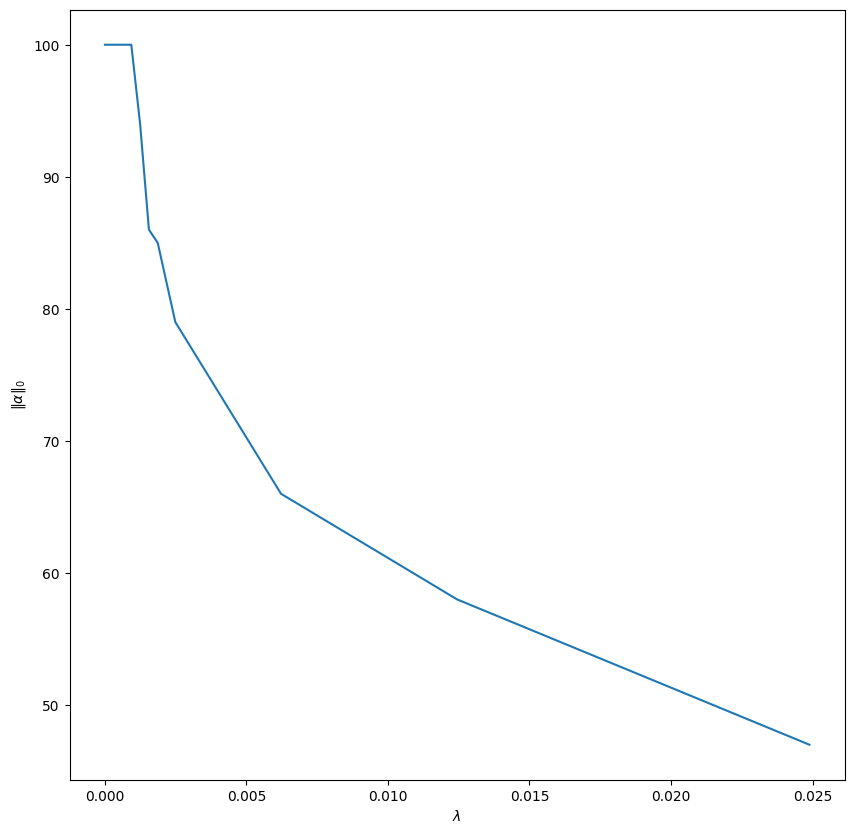

In [ ]:
figure, l0_ax = matplotlib.pyplot.subplots(figsize=(10, 10))
l0_ax.set_ylabel('$\|\\alpha\|_0$')
l0_ax.set_xlabel('$\lambda$')
l0_ax.plot([experiment['regularization'] for experiment in experiments_stage2], 
           [experiment['model_metrics'][-2]['non_zero_neurons'] for experiment in experiments_stage2])

figure

# Direct L1 minimization

In [43]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (norms_ax, loss_gradient_inner_product_to_norm_ratio_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=norms_ax)
plot_non_zero_norms = partial(plot_non_zero_norms, ax=norms_ax.twinx())
plot_loss_gradient_inner_product_to_norm_ratio = partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(height=1200, width=1200)

In [45]:
import scipy

def prune(self, inputs, labels):
    self(inputs)
    labels = ((labels * 2.) - 1.)
    outputs = self.activations[-1] * self.output_layer.weight
    current_margins = (labels * outputs.sum(dim=1)).detach().cpu().numpy()
    gamma = torch.diag(labels) @ (outputs.T / self.norms.unsqueeze(1)).T

    initial_solution = self.norms.detach().cpu().numpy()
    A = - gamma.detach().cpu().numpy()
    b = - current_margins
    c = torch.ones(len(initial_solution))
    
    final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x
    
    non_zero_neurons = final_solution.nonzero()[0]
    new_input_layer = torch.nn.Linear(self.input_dimension, len(non_zero_neurons), self.bias)
    new_output_layer = torch.nn.Linear(len(non_zero_neurons), 1 if self.classes <= 2 else self.classes, self.bias)
    with torch.no_grad():
        old_input_layer_normalized = self.layers[0].weight / self.layers[0].weight.norm(dim=0)
        old_output_layer_normalized = self.output_layer.weight / self.output_layer.weight.norm(dim=0)
        new_input_layer.weight.copy_(old_input_layer_normalized[non_zero_neurons] * (final_solution[non_zero_neurons] ** 0.5).reshape(-1,1))
        new_output_layer.weight.copy_(old_output_layer_normalized[:, non_zero_neurons] * final_solution[non_zero_neurons] ** 0.5)
        self.layers[0] = new_input_layer
        self.output_layer = new_output_layer

In [46]:
import copy
experiment_stage3 = {**copy.deepcopy(experiment), 'epochs': experiment['epochs'] * 2, 
                     'name_parameters': ['id'], 'id': 'L1_minimization_margin'}
new_model = FullyConnectedNeuralNetwork(**experiment)
with torch.no_grad():
    new_model.layers[0].weight.copy_(model.layers[0].weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

prune(new_model, inputs, labels)

experiment_stage3, model_stage3, device, generator_stage3 = execute_experiment(
    **experiment_stage3,
    model=new_model,
    model_class=FullyConnectedNeuralNetwork,
    train_data=train_data, 
    test_data=test_data, 
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment_stage3['epochs'], 100)),
    callbacks=[plot_samples_and_neurons, 
            plot_train_loss, plot_weights_norms, 
            plot_loss_gradient_inner_product_to_norm_ratio, 
            plot_non_zero_norms,
            draw_figure_into_canvas, save_figure],
    overwrite=True,
    train_data_callbacks=[model_summary]
)

/tmp/ipykernel_8977/61592154.py:15: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x


In [39]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (norms_ax, loss_gradient_inner_product_to_norm_ratio_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=norms_ax)
plot_non_zero_norms = partial(plot_non_zero_norms, ax=norms_ax.twinx())
plot_loss_gradient_inner_product_to_norm_ratio = partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(height=1200, width=1200)

In [40]:
import scipy

def prune(self, inputs, labels):
    self(inputs)
    labels = ((labels * 2.) - 1.)
    outputs = self.activations[-1] * self.output_layer.weight
    gamma = torch.diag(labels) @ (outputs.T / self.norms.unsqueeze(1)).T

    initial_solution = self.norms.detach().cpu().numpy()
    A = - gamma.detach().cpu().numpy()
    b = - torch.ones(len(labels)).numpy()
    c = torch.ones(len(initial_solution))
    
    final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x
    
    non_zero_neurons = final_solution.nonzero()[0]
    new_input_layer = torch.nn.Linear(self.input_dimension, len(non_zero_neurons), self.bias)
    new_output_layer = torch.nn.Linear(len(non_zero_neurons), 1 if self.classes <= 2 else self.classes, self.bias)
    with torch.no_grad():
        old_input_layer_normalized = self.layers[0].weight / self.layers[0].weight.norm(dim=0)
        old_output_layer_normalized = self.output_layer.weight / self.output_layer.weight.norm(dim=0)
        new_input_layer.weight.copy_(old_input_layer_normalized[non_zero_neurons] * (final_solution[non_zero_neurons] ** 0.5).reshape(-1,1))
        new_output_layer.weight.copy_(old_output_layer_normalized[:, non_zero_neurons] * final_solution[non_zero_neurons] ** 0.5)
        self.layers[0] = new_input_layer
        self.output_layer = new_output_layer

In [42]:
import copy
experiment_stage3 = {**copy.deepcopy(experiment), 'epochs': experiment['epochs'] * 2, 
                     'name_parameters': ['id'], 'id': 'L1_minimization'}
new_model = FullyConnectedNeuralNetwork(**experiment)
with torch.no_grad():
    new_model.layers[0].weight.copy_(model.layers[0].weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

prune(new_model, inputs, labels)

experiment_stage3, model_stage3, device, generator_stage3 = execute_experiment(
    **experiment_stage3,
    model=new_model,
    model_class=FullyConnectedNeuralNetwork,
    train_data=train_data, 
    test_data=test_data, 
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment_stage3['epochs'], 100)),
    callbacks=[plot_samples_and_neurons, 
            plot_train_loss, plot_weights_norms, 
            plot_loss_gradient_inner_product_to_norm_ratio, 
            plot_non_zero_norms,
            draw_figure_into_canvas, save_figure],
    overwrite=True,
    train_data_callbacks=[model_summary]
)

/tmp/ipykernel_8977/2161273466.py:14: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  final_solution = scipy.optimize.linprog(c, x0=initial_solution, A_ub=A, b_ub=b).x
